In [146]:
import pandas as pd
from functools import reduce
import numpy as np
import impyute as impy
from sklearn.metrics import mean_squared_error,r2_score
import datawig
from ppca import PPCA
from fancyimpute import NuclearNormMinimization, MatrixFactorization
import matplotlib.pyplot as plt

#### Data Preparation

In [55]:
def readtodf(filename, colname):
    a=filename+'.txt'
    data = pd.read_csv(a, sep=",", header=(0))
    data.columns=['a','Date',colname]
    data=data.drop('a',axis=1)
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')
    
    return data

In [56]:
target=readtodf('prod_target','Beer')
prod_1=readtodf('prod_1','Car')
prod_2=readtodf('prod_2','Steel')
eng_1=readtodf('eng_1','Gas')
eng_2=readtodf('eng_2','Electricity')

In [57]:
temp = pd.read_csv('temp.txt', sep=",", header=(0))
temp.columns=['num','year','month','Temp']
temp=temp.drop('num',axis=1)
temp['day']=1
temp['Date']=pd.to_datetime(temp[['year', 'month', 'day']])
temp=temp.drop(['year', 'month', 'day'],axis=1)
temp = temp.set_index('Date')

In [58]:
target.shape,prod_1.shape,prod_2.shape, eng_1.shape,eng_2.shape,temp.shape

((435, 1), (369, 1), (435, 1), (435, 1), (435, 1), (581, 1))

In [66]:
 # creat dataframe version of merged data
dfs = [target, prod_1, prod_2, eng_1,eng_2,temp]
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True,how='left'), dfs)
#df_final.to_csv('data_merged.csv')

# creat numpy version of merged data
np_final=np.array(df_final.values,dtype=np.float)

In [67]:
np_final.shape

(435, 6)

In [68]:
df_final.head()

,Beer,Car,Steel,Gas,Electricity,Temp
Date,,,,,,
1956-01-01,93.2,NaN,196.9,1709,1254,25.1
1956-02-01,96.0,NaN,192.1,1646,1290,25.3
1956-03-01,95.2,NaN,201.8,1794,1379,24.9
1956-04-01,77.1,NaN,186.9,1878,1346,23.9
1956-05-01,70.9,NaN,218.0,2173,1535,19.4


### Imputation

##### 1.Mice

The Multiple Imputation by Chained Equations (MICE) method is widely used in practice, which uses chain equations to create multiple imputations for variables of diferent types.

In [154]:
ip_mice=impy.imputation.cs.mice(np_final)
#np.savetxt('./Imputation Results/imputation_mice.csv',ip_mice,delimiter=",")

##### 2.KNN

- This method uses k-nearest neighbor to fInd similar samples and imputed unobserved data by weighted average of similar observations.
- Basic idea: Impute array with a basic mean impute and then use the resulting complete array to construct a KDTree. Use this KDTree to compute nearest neighbours. After finding k nearest neighbours, take the weighted average of them. Basically, find the nearest row in terms of distance

In [124]:
ip_knn=impy.imputation.cs.fast_knn(np_final)
#np.savetxt('./Imputation Results/imputation_knn.csv',ip_knn,delimiter=",")

##### 3.NuclearNormMinimization

Simple implementation of Exact Matrix Completion via Convex Optimization by Emmanuel Candes and Benjamin Recht using cvxpy. Too slow for large matrices.

In [26]:
X_filled_nnm = NuclearNormMinimization().fit_transform(np_final)

----------------------------------------------------------------------------
	SCS v2.1.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 115539
eps = 1.00e-04, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 102681, constraints m = 107901
Cones:	primal zero / dual free vars: 2610
	linear vars: 7830
	sd vars: 97461, sd blks: 1
Setup time: 7.49e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.43e+21  4.09e+21  1.00e+00 -3.84e+28  6.77e+27  8.25e+27  7.91e-02 
   100| 9.26e-04  9.60e-04  1.00e-04  1.02e+06  1.02e+06  5.96e-10  5.29e+00 
   200| 4.07e-04  3.60e-04  2.09e-04  1.02e+06  1.0

In [139]:
ip_nnm=X_filled_nnm

In [137]:
#np.savetxt('./Imputation Results/imputation_NuclearNormMinimization.csv',ipp_nnm,delimiter=",")

##### 4.MatrixFactorization

Direct factorization of the incomplete matrix into low-rank U and V, with an L1 sparsity penalty on the elements of U and an L2 penalty on the elements of V. Solved by gradient descent.

In [73]:
missing_value_mask=np.ma.getmaskarray(np.ma.masked_invalid(np_final))

In [75]:
np.savetxt('Mask.csv',missing_value_mask,delimiter=',')

In [77]:
ip_mf=MatrixFactorization().solve(X=np_final.copy(),missing_mask=missing_value_mask)

Train on 2262 samples, validate on 252 samples
Epoch 1/10000
2262/2262 [==============================] - 1s 447us/step - loss: 249599472.0000 - val_loss: 213857712.0000
Epoch 2/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249599392.0000 - val_loss: 213857680.0000
Epoch 3/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249599328.0000 - val_loss: 213857648.0000
Epoch 4/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249599248.0000 - val_loss: 213857616.0000
Epoch 5/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249599136.0000 - val_loss: 213857584.0000
Epoch 6/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249599072.0000 - val_loss: 213857552.0000
Epoch 7/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249599040.0000 - val_loss: 213857504.0000
Epoch 8/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249598960.0000 - val_loss

Epoch 68/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249592528.0000 - val_loss: 213853888.0000
Epoch 69/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249592464.0000 - val_loss: 213853792.0000
Epoch 70/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249592384.0000 - val_loss: 213853728.0000
Epoch 71/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249592240.0000 - val_loss: 213853648.0000
Epoch 72/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249592144.0000 - val_loss: 213853552.0000
Epoch 73/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249591968.0000 - val_loss: 213853456.0000
Epoch 74/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249591824.0000 - val_loss: 213853360.0000
Epoch 75/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249591680.0000 - val_loss: 213853280.0000
Epoch 76/10000
2262/2262

Epoch 135/10000
2262/2262 [==============================] - 0s 4us/step - loss: 249582272.0000 - val_loss: 213846368.0000
Epoch 136/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249582032.0000 - val_loss: 213846240.0000
Epoch 137/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249581856.0000 - val_loss: 213846096.0000
Epoch 138/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249581680.0000 - val_loss: 213845952.0000
Epoch 139/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249581536.0000 - val_loss: 213845824.0000
Epoch 140/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249581344.0000 - val_loss: 213845664.0000
Epoch 141/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249581136.0000 - val_loss: 213845536.0000
Epoch 142/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249581024.0000 - val_loss: 213845376.0000
Epoch 143/10000


Epoch 202/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249568128.0000 - val_loss: 213835088.0000
Epoch 203/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249567776.0000 - val_loss: 213834880.0000
Epoch 204/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249567520.0000 - val_loss: 213834672.0000
Epoch 205/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249567344.0000 - val_loss: 213834480.0000
Epoch 206/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249567088.0000 - val_loss: 213834288.0000
Epoch 207/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249566912.0000 - val_loss: 213834080.0000
Epoch 208/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249566592.0000 - val_loss: 213833856.0000
Epoch 209/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249566368.0000 - val_loss: 213833696.0000
Epoch 210/10000


Epoch 269/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249549984.0000 - val_loss: 213820320.0000
Epoch 270/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249549680.0000 - val_loss: 213820048.0000
Epoch 271/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249549376.0000 - val_loss: 213819808.0000
Epoch 272/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249549040.0000 - val_loss: 213819552.0000
Epoch 273/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249548688.0000 - val_loss: 213819312.0000
Epoch 274/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249548448.0000 - val_loss: 213819072.0000
Epoch 275/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249548112.0000 - val_loss: 213818816.0000
Epoch 276/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249547824.0000 - val_loss: 213818576.0000
Epoch 277/10000


Epoch 336/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249527856.0000 - val_loss: 213802448.0000
Epoch 337/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249527568.0000 - val_loss: 213802192.0000
Epoch 338/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249527216.0000 - val_loss: 213801888.0000
Epoch 339/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249526816.0000 - val_loss: 213801616.0000
Epoch 340/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249526400.0000 - val_loss: 213801312.0000
Epoch 341/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249526064.0000 - val_loss: 213801008.0000
Epoch 342/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249525776.0000 - val_loss: 213800704.0000
Epoch 343/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249525456.0000 - val_loss: 213800432.0000
Epoch 344/10000


Epoch 403/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249502048.0000 - val_loss: 213781680.0000
Epoch 404/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249501760.0000 - val_loss: 213781344.0000
Epoch 405/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249501296.0000 - val_loss: 213781024.0000
Epoch 406/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249500848.0000 - val_loss: 213780672.0000
Epoch 407/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249500512.0000 - val_loss: 213780336.0000
Epoch 408/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249500016.0000 - val_loss: 213780032.0000
Epoch 409/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249499616.0000 - val_loss: 213779680.0000
Epoch 410/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249499168.0000 - val_loss: 213779376.0000
Epoch 411/10000


Epoch 470/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249472640.0000 - val_loss: 213758016.0000
Epoch 471/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249472176.0000 - val_loss: 213757632.0000
Epoch 472/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249471680.0000 - val_loss: 213757280.0000
Epoch 473/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249471184.0000 - val_loss: 213756896.0000
Epoch 474/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249470784.0000 - val_loss: 213756528.0000
Epoch 475/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249470288.0000 - val_loss: 213756160.0000
Epoch 476/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249469856.0000 - val_loss: 213755760.0000
Epoch 477/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249469360.0000 - val_loss: 213755376.0000
Epoch 478/10000


Epoch 537/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249439600.0000 - val_loss: 213731552.0000
Epoch 538/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249438976.0000 - val_loss: 213731136.0000
Epoch 539/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249438512.0000 - val_loss: 213730704.0000
Epoch 540/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249437952.0000 - val_loss: 213730304.0000
Epoch 541/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249437456.0000 - val_loss: 213729888.0000
Epoch 542/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249436880.0000 - val_loss: 213729472.0000
Epoch 543/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249436336.0000 - val_loss: 213729056.0000
Epoch 544/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249435808.0000 - val_loss: 213728608.0000
Epoch 545/10000


Epoch 604/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249402896.0000 - val_loss: 213702336.0000
Epoch 605/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249402352.0000 - val_loss: 213701872.0000
Epoch 606/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249401760.0000 - val_loss: 213701424.0000
Epoch 607/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249401152.0000 - val_loss: 213700960.0000
Epoch 608/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249400608.0000 - val_loss: 213700480.0000
Epoch 609/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249400000.0000 - val_loss: 213700048.0000
Epoch 610/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249399456.0000 - val_loss: 213699600.0000
Epoch 611/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249398896.0000 - val_loss: 213699136.0000
Epoch 612/10000


Epoch 671/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249362880.0000 - val_loss: 213670448.0000
Epoch 672/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249362304.0000 - val_loss: 213669952.0000
Epoch 673/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249361648.0000 - val_loss: 213669440.0000
Epoch 674/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249360976.0000 - val_loss: 213668944.0000
Epoch 675/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249360416.0000 - val_loss: 213668464.0000
Epoch 676/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249359728.0000 - val_loss: 213667952.0000
Epoch 677/10000
2262/2262 [==============================] - 0s 4us/step - loss: 249359120.0000 - val_loss: 213667456.0000
Epoch 678/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249358512.0000 - val_loss: 213666944.0000
Epoch 679/10000


Epoch 738/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249319488.0000 - val_loss: 213635888.0000
Epoch 739/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249318816.0000 - val_loss: 213635344.0000
Epoch 740/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249318208.0000 - val_loss: 213634800.0000
Epoch 741/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249317376.0000 - val_loss: 213634272.0000
Epoch 742/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249316816.0000 - val_loss: 213633744.0000
Epoch 743/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249316128.0000 - val_loss: 213633184.0000
Epoch 744/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249315408.0000 - val_loss: 213632672.0000
Epoch 745/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249314768.0000 - val_loss: 213632144.0000
Epoch 746/10000


Epoch 805/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249272816.0000 - val_loss: 213598832.0000
Epoch 806/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249272080.0000 - val_loss: 213598240.0000
Epoch 807/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249271360.0000 - val_loss: 213597648.0000
Epoch 808/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249270688.0000 - val_loss: 213597072.0000
Epoch 809/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249269920.0000 - val_loss: 213596512.0000
Epoch 810/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249269184.0000 - val_loss: 213595968.0000
Epoch 811/10000
2262/2262 [==============================] - 0s 4us/step - loss: 249268400.0000 - val_loss: 213595360.0000
Epoch 812/10000
2262/2262 [==============================] - 0s 4us/step - loss: 249267744.0000 - val_loss: 213594800.0000
Epoch 813/10000


Epoch 872/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249223040.0000 - val_loss: 213559184.0000
Epoch 873/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249222160.0000 - val_loss: 213558576.0000
Epoch 874/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249221472.0000 - val_loss: 213557984.0000
Epoch 875/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249220688.0000 - val_loss: 213557344.0000
Epoch 876/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249219936.0000 - val_loss: 213556752.0000
Epoch 877/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249219120.0000 - val_loss: 213556144.0000
Epoch 878/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249218336.0000 - val_loss: 213555520.0000
Epoch 879/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249217712.0000 - val_loss: 213554912.0000
Epoch 880/10000


Epoch 939/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249170096.0000 - val_loss: 213517168.0000
Epoch 940/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249169200.0000 - val_loss: 213516496.0000
Epoch 941/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249168400.0000 - val_loss: 213515872.0000
Epoch 942/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249167616.0000 - val_loss: 213515232.0000
Epoch 943/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249166832.0000 - val_loss: 213514576.0000
Epoch 944/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249166016.0000 - val_loss: 213513920.0000
Epoch 945/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249165200.0000 - val_loss: 213513296.0000
Epoch 946/10000
2262/2262 [==============================] - 0s 3us/step - loss: 249164304.0000 - val_loss: 213512608.0000
Epoch 947/10000


Epoch 1006/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249114048.0000 - val_loss: 213472688.0000
Epoch 1007/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249113200.0000 - val_loss: 213472016.0000
Epoch 1008/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249112384.0000 - val_loss: 213471360.0000
Epoch 1009/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249111456.0000 - val_loss: 213470640.0000
Epoch 1010/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249110512.0000 - val_loss: 213469984.0000
Epoch 1011/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249109760.0000 - val_loss: 213469312.0000
Epoch 1012/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249108912.0000 - val_loss: 213468624.0000
Epoch 1013/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249108048.0000 - val_loss: 213467920.0000
Epoch 10

2262/2262 [==============================] - 0s 2us/step - loss: 249056128.0000 - val_loss: 213426656.0000
Epoch 1073/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249055088.0000 - val_loss: 213425968.0000
Epoch 1074/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249054208.0000 - val_loss: 213425264.0000
Epoch 1075/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249053280.0000 - val_loss: 213424512.0000
Epoch 1076/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249052448.0000 - val_loss: 213423792.0000
Epoch 1077/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249051520.0000 - val_loss: 213423088.0000
Epoch 1078/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249050560.0000 - val_loss: 213422400.0000
Epoch 1079/10000
2262/2262 [==============================] - 0s 2us/step - loss: 249049696.0000 - val_loss: 213421664.0000
Epoch 1080/10000
2262/226

Epoch 1139/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248994176.0000 - val_loss: 213377680.0000
Epoch 1140/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248993280.0000 - val_loss: 213376928.0000
Epoch 1141/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248992320.0000 - val_loss: 213376176.0000
Epoch 1142/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248991376.0000 - val_loss: 213375360.0000
Epoch 1143/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248990448.0000 - val_loss: 213374656.0000
Epoch 1144/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248989488.0000 - val_loss: 213373888.0000
Epoch 1145/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248988496.0000 - val_loss: 213373152.0000
Epoch 1146/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248987664.0000 - val_loss: 213372400.0000
Epoch 11

2262/2262 [==============================] - 0s 2us/step - loss: 248930592.0000 - val_loss: 213327216.0000
Epoch 1206/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248929568.0000 - val_loss: 213326432.0000
Epoch 1207/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248928496.0000 - val_loss: 213325632.0000
Epoch 1208/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248927600.0000 - val_loss: 213324848.0000
Epoch 1209/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248926560.0000 - val_loss: 213324064.0000
Epoch 1210/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248925568.0000 - val_loss: 213323280.0000
Epoch 1211/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248924624.0000 - val_loss: 213322496.0000
Epoch 1212/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248923568.0000 - val_loss: 213321728.0000
Epoch 1213/10000
2262/226

Epoch 1272/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248863168.0000 - val_loss: 213273840.0000
Epoch 1273/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248862096.0000 - val_loss: 213272976.0000
Epoch 1274/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248861104.0000 - val_loss: 213272192.0000
Epoch 1275/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248860128.0000 - val_loss: 213271408.0000
Epoch 1276/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248859088.0000 - val_loss: 213270560.0000
Epoch 1277/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248857888.0000 - val_loss: 213269728.0000
Epoch 1278/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248856992.0000 - val_loss: 213268896.0000
Epoch 1279/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248855888.0000 - val_loss: 213268096.0000
Epoch 12

2262/2262 [==============================] - 0s 3us/step - loss: 248794096.0000 - val_loss: 213219136.0000
Epoch 1339/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248793024.0000 - val_loss: 213218304.0000
Epoch 1340/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248791952.0000 - val_loss: 213217456.0000
Epoch 1341/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248790944.0000 - val_loss: 213216592.0000
Epoch 1342/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248789840.0000 - val_loss: 213215776.0000
Epoch 1343/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248788736.0000 - val_loss: 213214928.0000
Epoch 1344/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248787744.0000 - val_loss: 213214064.0000
Epoch 1345/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248786560.0000 - val_loss: 213213216.0000
Epoch 1346/10000
2262/226

Epoch 1405/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248721312.0000 - val_loss: 213161584.0000
Epoch 1406/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248720272.0000 - val_loss: 213160720.0000
Epoch 1407/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248719120.0000 - val_loss: 213159856.0000
Epoch 1408/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248718080.0000 - val_loss: 213158960.0000
Epoch 1409/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248716976.0000 - val_loss: 213158080.0000
Epoch 1410/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248715840.0000 - val_loss: 213157200.0000
Epoch 1411/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248714768.0000 - val_loss: 213156320.0000
Epoch 1412/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248713632.0000 - val_loss: 213155472.0000
Epoch 14

2262/2262 [==============================] - 0s 2us/step - loss: 248647200.0000 - val_loss: 213102912.0000
Epoch 1472/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248646080.0000 - val_loss: 213101984.0000
Epoch 1473/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248644912.0000 - val_loss: 213101088.0000
Epoch 1474/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248643728.0000 - val_loss: 213100160.0000
Epoch 1475/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248642624.0000 - val_loss: 213099264.0000
Epoch 1476/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248641504.0000 - val_loss: 213098368.0000
Epoch 1477/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248640336.0000 - val_loss: 213097456.0000
Epoch 1478/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248639296.0000 - val_loss: 213096544.0000
Epoch 1479/10000
2262/226

Epoch 1538/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248569392.0000 - val_loss: 213041344.0000
Epoch 1539/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248568112.0000 - val_loss: 213040432.0000
Epoch 1540/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248567008.0000 - val_loss: 213039488.0000
Epoch 1541/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248565824.0000 - val_loss: 213038544.0000
Epoch 1542/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248564656.0000 - val_loss: 213037616.0000
Epoch 1543/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248563360.0000 - val_loss: 213036672.0000
Epoch 1544/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248562256.0000 - val_loss: 213035760.0000
Epoch 1545/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248561104.0000 - val_loss: 213034800.0000
Epoch 15

2262/2262 [==============================] - 0s 2us/step - loss: 248490288.0000 - val_loss: 212978832.0000
Epoch 1605/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248489040.0000 - val_loss: 212977856.0000
Epoch 1606/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248487824.0000 - val_loss: 212976896.0000
Epoch 1607/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248486640.0000 - val_loss: 212975936.0000
Epoch 1608/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248485392.0000 - val_loss: 212974960.0000
Epoch 1609/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248484176.0000 - val_loss: 212973984.0000
Epoch 1610/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248482928.0000 - val_loss: 212973008.0000
Epoch 1611/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248481632.0000 - val_loss: 212972080.0000
Epoch 1612/10000
2262/226

Epoch 1671/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248407520.0000 - val_loss: 212913424.0000
Epoch 1672/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248406160.0000 - val_loss: 212912416.0000
Epoch 1673/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248404960.0000 - val_loss: 212911440.0000
Epoch 1674/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248403808.0000 - val_loss: 212910464.0000
Epoch 1675/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248402480.0000 - val_loss: 212909456.0000
Epoch 1676/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248401232.0000 - val_loss: 212908432.0000
Epoch 1677/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248399952.0000 - val_loss: 212907472.0000
Epoch 1678/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248398736.0000 - val_loss: 212906512.0000
Epoch 16

2262/2262 [==============================] - 0s 2us/step - loss: 248323552.0000 - val_loss: 212847216.0000
Epoch 1738/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248322272.0000 - val_loss: 212846208.0000
Epoch 1739/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248320976.0000 - val_loss: 212845168.0000
Epoch 1740/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248319648.0000 - val_loss: 212844192.0000
Epoch 1741/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248318400.0000 - val_loss: 212843136.0000
Epoch 1742/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248317088.0000 - val_loss: 212842112.0000
Epoch 1743/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248315792.0000 - val_loss: 212841088.0000
Epoch 1744/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248314544.0000 - val_loss: 212840064.0000
Epoch 1745/10000
2262/226

Epoch 1804/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248236144.0000 - val_loss: 212778160.0000
Epoch 1805/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248234752.0000 - val_loss: 212777120.0000
Epoch 1806/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248233392.0000 - val_loss: 212776064.0000
Epoch 1807/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248232112.0000 - val_loss: 212775040.0000
Epoch 1808/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248230816.0000 - val_loss: 212773984.0000
Epoch 1809/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248229456.0000 - val_loss: 212772928.0000
Epoch 1810/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248228064.0000 - val_loss: 212771904.0000
Epoch 1811/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248226752.0000 - val_loss: 212770848.0000
Epoch 18

2262/2262 [==============================] - 0s 3us/step - loss: 248147520.0000 - val_loss: 212708368.0000
Epoch 1871/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248146240.0000 - val_loss: 212707312.0000
Epoch 1872/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248144848.0000 - val_loss: 212706256.0000
Epoch 1873/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248143488.0000 - val_loss: 212705184.0000
Epoch 1874/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248142096.0000 - val_loss: 212704112.0000
Epoch 1875/10000
2262/2262 [==============================] - 0s 3us/step - loss: 248140816.0000 - val_loss: 212703040.0000
Epoch 1876/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248139408.0000 - val_loss: 212701968.0000
Epoch 1877/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248138064.0000 - val_loss: 212700880.0000
Epoch 1878/10000
2262/226

Epoch 1937/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248055376.0000 - val_loss: 212635808.0000
Epoch 1938/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248054112.0000 - val_loss: 212634736.0000
Epoch 1939/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248052752.0000 - val_loss: 212633648.0000
Epoch 1940/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248051296.0000 - val_loss: 212632528.0000
Epoch 1941/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248049792.0000 - val_loss: 212631456.0000
Epoch 1942/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248048576.0000 - val_loss: 212630352.0000
Epoch 1943/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248047072.0000 - val_loss: 212629232.0000
Epoch 1944/10000
2262/2262 [==============================] - 0s 2us/step - loss: 248045680.0000 - val_loss: 212628144.0000
Epoch 19

2262/2262 [==============================] - 0s 2us/step - loss: 247962560.0000 - val_loss: 212562640.0000
Epoch 2004/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247961024.0000 - val_loss: 212561536.0000
Epoch 2005/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247959600.0000 - val_loss: 212560432.0000
Epoch 2006/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247958272.0000 - val_loss: 212559280.0000
Epoch 2007/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247956816.0000 - val_loss: 212558160.0000
Epoch 2008/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247955376.0000 - val_loss: 212557040.0000
Epoch 2009/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247954032.0000 - val_loss: 212555904.0000
Epoch 2010/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247952560.0000 - val_loss: 212554784.0000
Epoch 2011/10000
2262/226

Epoch 2070/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247865984.0000 - val_loss: 212486704.0000
Epoch 2071/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247864512.0000 - val_loss: 212485536.0000
Epoch 2072/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247863040.0000 - val_loss: 212484384.0000
Epoch 2073/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247861552.0000 - val_loss: 212483264.0000
Epoch 2074/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247860160.0000 - val_loss: 212482080.0000
Epoch 2075/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247858720.0000 - val_loss: 212480944.0000
Epoch 2076/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247857232.0000 - val_loss: 212479792.0000
Epoch 2077/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247855760.0000 - val_loss: 212478624.0000
Epoch 20

2262/2262 [==============================] - 0s 3us/step - loss: 247768720.0000 - val_loss: 212410208.0000
Epoch 2137/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247767280.0000 - val_loss: 212409040.0000
Epoch 2138/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247765808.0000 - val_loss: 212407856.0000
Epoch 2139/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247764272.0000 - val_loss: 212406688.0000
Epoch 2140/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247762736.0000 - val_loss: 212405520.0000
Epoch 2141/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247761312.0000 - val_loss: 212404352.0000
Epoch 2142/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247759808.0000 - val_loss: 212403184.0000
Epoch 2143/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247758320.0000 - val_loss: 212402016.0000
Epoch 2144/10000
2262/226

Epoch 2203/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247667968.0000 - val_loss: 212330960.0000
Epoch 2204/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247666432.0000 - val_loss: 212329760.0000
Epoch 2205/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247664864.0000 - val_loss: 212328560.0000
Epoch 2206/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247663328.0000 - val_loss: 212327376.0000
Epoch 2207/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247661840.0000 - val_loss: 212326192.0000
Epoch 2208/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247660320.0000 - val_loss: 212324976.0000
Epoch 2209/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247658832.0000 - val_loss: 212323760.0000
Epoch 2210/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247657296.0000 - val_loss: 212322592.0000
Epoch 22

2262/2262 [==============================] - 0s 3us/step - loss: 247566560.0000 - val_loss: 212251296.0000
Epoch 2270/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247564992.0000 - val_loss: 212250096.0000
Epoch 2271/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247563456.0000 - val_loss: 212248880.0000
Epoch 2272/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247561888.0000 - val_loss: 212247664.0000
Epoch 2273/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247560272.0000 - val_loss: 212246432.0000
Epoch 2274/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247558800.0000 - val_loss: 212245232.0000
Epoch 2275/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247557264.0000 - val_loss: 212244000.0000
Epoch 2276/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247555728.0000 - val_loss: 212242784.0000
Epoch 2277/10000
2262/226

Epoch 2336/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247461568.0000 - val_loss: 212168896.0000
Epoch 2337/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247460032.0000 - val_loss: 212167664.0000
Epoch 2338/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247458432.0000 - val_loss: 212166432.0000
Epoch 2339/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247456832.0000 - val_loss: 212165168.0000
Epoch 2340/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247455248.0000 - val_loss: 212163920.0000
Epoch 2341/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247453568.0000 - val_loss: 212162688.0000
Epoch 2342/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247452080.0000 - val_loss: 212161456.0000
Epoch 2343/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247450528.0000 - val_loss: 212160192.0000
Epoch 23

2262/2262 [==============================] - 0s 2us/step - loss: 247356160.0000 - val_loss: 212086144.0000
Epoch 2403/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247354592.0000 - val_loss: 212084896.0000
Epoch 2404/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247352976.0000 - val_loss: 212083648.0000
Epoch 2405/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247351296.0000 - val_loss: 212082400.0000
Epoch 2406/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247349632.0000 - val_loss: 212081120.0000
Epoch 2407/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247348096.0000 - val_loss: 212079824.0000
Epoch 2408/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247346480.0000 - val_loss: 212078576.0000
Epoch 2409/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247344864.0000 - val_loss: 212077312.0000
Epoch 2410/10000
2262/226

Epoch 2469/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247247136.0000 - val_loss: 212000672.0000
Epoch 2470/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247245536.0000 - val_loss: 211999344.0000
Epoch 2471/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247243920.0000 - val_loss: 211998064.0000
Epoch 2472/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247242272.0000 - val_loss: 211996784.0000
Epoch 2473/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247240560.0000 - val_loss: 211995520.0000
Epoch 2474/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247238960.0000 - val_loss: 211994240.0000
Epoch 2475/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247237312.0000 - val_loss: 211992928.0000
Epoch 2476/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247235632.0000 - val_loss: 211991648.0000
Epoch 24

2262/2262 [==============================] - 0s 3us/step - loss: 247137728.0000 - val_loss: 211914944.0000
Epoch 2536/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247136176.0000 - val_loss: 211913648.0000
Epoch 2537/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247134464.0000 - val_loss: 211912336.0000
Epoch 2538/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247132688.0000 - val_loss: 211911040.0000
Epoch 2539/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247131120.0000 - val_loss: 211909712.0000
Epoch 2540/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247129440.0000 - val_loss: 211908416.0000
Epoch 2541/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247127760.0000 - val_loss: 211907088.0000
Epoch 2542/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247126112.0000 - val_loss: 211905792.0000
Epoch 2543/10000
2262/226

Epoch 2602/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247024768.0000 - val_loss: 211826480.0000
Epoch 2603/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247023120.0000 - val_loss: 211825120.0000
Epoch 2604/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247021472.0000 - val_loss: 211823776.0000
Epoch 2605/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247019664.0000 - val_loss: 211822464.0000
Epoch 2606/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247017984.0000 - val_loss: 211821136.0000
Epoch 2607/10000
2262/2262 [==============================] - 0s 3us/step - loss: 247016288.0000 - val_loss: 211819792.0000
Epoch 2608/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247014576.0000 - val_loss: 211818464.0000
Epoch 2609/10000
2262/2262 [==============================] - 0s 2us/step - loss: 247012896.0000 - val_loss: 211817136.0000
Epoch 26

2262/2262 [==============================] - 0s 2us/step - loss: 246911600.0000 - val_loss: 211737808.0000
Epoch 2669/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246909920.0000 - val_loss: 211736512.0000
Epoch 2670/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246908160.0000 - val_loss: 211735120.0000
Epoch 2671/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246906448.0000 - val_loss: 211733776.0000
Epoch 2672/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246904672.0000 - val_loss: 211732416.0000
Epoch 2673/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246902992.0000 - val_loss: 211731072.0000
Epoch 2674/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246901200.0000 - val_loss: 211729712.0000
Epoch 2675/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246899488.0000 - val_loss: 211728352.0000
Epoch 2676/10000
2262/226

Epoch 2735/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246794848.0000 - val_loss: 211646448.0000
Epoch 2736/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246793040.0000 - val_loss: 211645072.0000
Epoch 2737/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246791344.0000 - val_loss: 211643664.0000
Epoch 2738/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246789536.0000 - val_loss: 211642304.0000
Epoch 2739/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246787824.0000 - val_loss: 211640944.0000
Epoch 2740/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246786000.0000 - val_loss: 211639568.0000
Epoch 2741/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246784240.0000 - val_loss: 211638176.0000
Epoch 2742/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246782560.0000 - val_loss: 211636816.0000
Epoch 27

2262/2262 [==============================] - 0s 3us/step - loss: 246677936.0000 - val_loss: 211554976.0000
Epoch 2802/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246676176.0000 - val_loss: 211553552.0000
Epoch 2803/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246674288.0000 - val_loss: 211552160.0000
Epoch 2804/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246672432.0000 - val_loss: 211550800.0000
Epoch 2805/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246670816.0000 - val_loss: 211549392.0000
Epoch 2806/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246668960.0000 - val_loss: 211547968.0000
Epoch 2807/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246667136.0000 - val_loss: 211546576.0000
Epoch 2808/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246665392.0000 - val_loss: 211545184.0000
Epoch 2809/10000
2262/226

Epoch 2868/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246557376.0000 - val_loss: 211460720.0000
Epoch 2869/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246555552.0000 - val_loss: 211459280.0000
Epoch 2870/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246553712.0000 - val_loss: 211457904.0000
Epoch 2871/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246551856.0000 - val_loss: 211456464.0000
Epoch 2872/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246550048.0000 - val_loss: 211455056.0000
Epoch 2873/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246548320.0000 - val_loss: 211453648.0000
Epoch 2874/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246546400.0000 - val_loss: 211452240.0000
Epoch 2875/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246544608.0000 - val_loss: 211450800.0000
Epoch 28

2262/2262 [==============================] - 0s 3us/step - loss: 246436736.0000 - val_loss: 211366496.0000
Epoch 2935/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246434832.0000 - val_loss: 211365072.0000
Epoch 2936/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246433088.0000 - val_loss: 211363616.0000
Epoch 2937/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246431184.0000 - val_loss: 211362160.0000
Epoch 2938/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246429376.0000 - val_loss: 211360720.0000
Epoch 2939/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246427536.0000 - val_loss: 211359296.0000
Epoch 2940/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246425648.0000 - val_loss: 211357872.0000
Epoch 2941/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246423856.0000 - val_loss: 211356400.0000
Epoch 2942/10000
2262/226

Epoch 3001/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246312560.0000 - val_loss: 211269440.0000
Epoch 3002/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246310656.0000 - val_loss: 211267952.0000
Epoch 3003/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246308736.0000 - val_loss: 211266512.0000
Epoch 3004/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246306880.0000 - val_loss: 211265056.0000
Epoch 3005/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246304976.0000 - val_loss: 211263584.0000
Epoch 3006/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246303232.0000 - val_loss: 211262128.0000
Epoch 3007/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246301296.0000 - val_loss: 211260656.0000
Epoch 3008/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246299504.0000 - val_loss: 211259216.0000
Epoch 30

2262/2262 [==============================] - 0s 3us/step - loss: 246188272.0000 - val_loss: 211172464.0000
Epoch 3068/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246186448.0000 - val_loss: 211171008.0000
Epoch 3069/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246184560.0000 - val_loss: 211169504.0000
Epoch 3070/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246182592.0000 - val_loss: 211168016.0000
Epoch 3071/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246180736.0000 - val_loss: 211166560.0000
Epoch 3072/10000
2262/2262 [==============================] - 0s 2us/step - loss: 246178864.0000 - val_loss: 211165088.0000
Epoch 3073/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246176944.0000 - val_loss: 211163584.0000
Epoch 3074/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246175040.0000 - val_loss: 211162112.0000
Epoch 3075/10000
2262/226

Epoch 3134/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246060448.0000 - val_loss: 211072720.0000
Epoch 3135/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246058624.0000 - val_loss: 211071216.0000
Epoch 3136/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246056624.0000 - val_loss: 211069728.0000
Epoch 3137/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246054736.0000 - val_loss: 211068224.0000
Epoch 3138/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246052800.0000 - val_loss: 211066736.0000
Epoch 3139/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246050848.0000 - val_loss: 211065200.0000
Epoch 3140/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246049024.0000 - val_loss: 211063712.0000
Epoch 3141/10000
2262/2262 [==============================] - 0s 3us/step - loss: 246047056.0000 - val_loss: 211062192.0000
Epoch 31

2262/2262 [==============================] - 0s 3us/step - loss: 245932816.0000 - val_loss: 210973088.0000
Epoch 3201/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245930816.0000 - val_loss: 210971600.0000
Epoch 3202/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245928880.0000 - val_loss: 210970048.0000
Epoch 3203/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245926976.0000 - val_loss: 210968544.0000
Epoch 3204/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245924992.0000 - val_loss: 210967024.0000
Epoch 3205/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245923120.0000 - val_loss: 210965520.0000
Epoch 3206/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245921152.0000 - val_loss: 210963984.0000
Epoch 3207/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245919152.0000 - val_loss: 210962480.0000
Epoch 3208/10000
2262/226

Epoch 3267/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245801408.0000 - val_loss: 210870640.0000
Epoch 3268/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245799488.0000 - val_loss: 210869120.0000
Epoch 3269/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245797456.0000 - val_loss: 210867584.0000
Epoch 3270/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245795488.0000 - val_loss: 210866064.0000
Epoch 3271/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245793616.0000 - val_loss: 210864512.0000
Epoch 3272/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245791584.0000 - val_loss: 210862960.0000
Epoch 3273/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245789552.0000 - val_loss: 210861424.0000
Epoch 3274/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245787616.0000 - val_loss: 210859888.0000
Epoch 32

2262/2262 [==============================] - 0s 2us/step - loss: 245670272.0000 - val_loss: 210768448.0000
Epoch 3334/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245668336.0000 - val_loss: 210766880.0000
Epoch 3335/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245666304.0000 - val_loss: 210765344.0000
Epoch 3336/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245664304.0000 - val_loss: 210763776.0000
Epoch 3337/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245662336.0000 - val_loss: 210762208.0000
Epoch 3338/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245660240.0000 - val_loss: 210760656.0000
Epoch 3339/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245658304.0000 - val_loss: 210759056.0000
Epoch 3340/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245656304.0000 - val_loss: 210757520.0000
Epoch 3341/10000
2262/226

Epoch 3400/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245535488.0000 - val_loss: 210663360.0000
Epoch 3401/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245533408.0000 - val_loss: 210661792.0000
Epoch 3402/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245531408.0000 - val_loss: 210660208.0000
Epoch 3403/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245529376.0000 - val_loss: 210658608.0000
Epoch 3404/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245527328.0000 - val_loss: 210657056.0000
Epoch 3405/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245525264.0000 - val_loss: 210655456.0000
Epoch 3406/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245523232.0000 - val_loss: 210653888.0000
Epoch 3407/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245521200.0000 - val_loss: 210652288.0000
Epoch 34

2262/2262 [==============================] - 0s 3us/step - loss: 245400944.0000 - val_loss: 210558592.0000
Epoch 3467/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245398880.0000 - val_loss: 210556992.0000
Epoch 3468/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245396864.0000 - val_loss: 210555408.0000
Epoch 3469/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245394832.0000 - val_loss: 210553808.0000
Epoch 3470/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245392720.0000 - val_loss: 210552208.0000
Epoch 3471/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245390720.0000 - val_loss: 210550592.0000
Epoch 3472/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245388656.0000 - val_loss: 210548992.0000
Epoch 3473/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245386512.0000 - val_loss: 210547376.0000
Epoch 3474/10000
2262/226

Epoch 3533/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245262720.0000 - val_loss: 210450912.0000
Epoch 3534/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245260656.0000 - val_loss: 210449328.0000
Epoch 3535/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245258512.0000 - val_loss: 210447696.0000
Epoch 3536/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245256480.0000 - val_loss: 210446080.0000
Epoch 3537/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245254368.0000 - val_loss: 210444464.0000
Epoch 3538/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245252288.0000 - val_loss: 210442832.0000
Epoch 3539/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245250256.0000 - val_loss: 210441232.0000
Epoch 3540/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245248144.0000 - val_loss: 210439600.0000
Epoch 35

2262/2262 [==============================] - 0s 2us/step - loss: 245124800.0000 - val_loss: 210343648.0000
Epoch 3600/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245122688.0000 - val_loss: 210341984.0000
Epoch 3601/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245120640.0000 - val_loss: 210340336.0000
Epoch 3602/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245118512.0000 - val_loss: 210338704.0000
Epoch 3603/10000
2262/2262 [==============================] - 0s 2us/step - loss: 245116400.0000 - val_loss: 210337072.0000
Epoch 3604/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245114320.0000 - val_loss: 210335456.0000
Epoch 3605/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245112256.0000 - val_loss: 210333824.0000
Epoch 3606/10000
2262/2262 [==============================] - 0s 3us/step - loss: 245110144.0000 - val_loss: 210332176.0000
Epoch 3607/10000
2262/226

Epoch 3666/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244983216.0000 - val_loss: 210233456.0000
Epoch 3667/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244981136.0000 - val_loss: 210231776.0000
Epoch 3668/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244978960.0000 - val_loss: 210230128.0000
Epoch 3669/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244976896.0000 - val_loss: 210228480.0000
Epoch 3670/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244974752.0000 - val_loss: 210226848.0000
Epoch 3671/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244972576.0000 - val_loss: 210225152.0000
Epoch 3672/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244970432.0000 - val_loss: 210223520.0000
Epoch 3673/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244968384.0000 - val_loss: 210221856.0000
Epoch 36

2262/2262 [==============================] - 0s 3us/step - loss: 244842112.0000 - val_loss: 210123680.0000
Epoch 3733/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244839968.0000 - val_loss: 210122000.0000
Epoch 3734/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244837744.0000 - val_loss: 210120352.0000
Epoch 3735/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244835632.0000 - val_loss: 210118656.0000
Epoch 3736/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244833520.0000 - val_loss: 210116960.0000
Epoch 3737/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244831344.0000 - val_loss: 210115312.0000
Epoch 3738/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244829136.0000 - val_loss: 210113648.0000
Epoch 3739/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244827088.0000 - val_loss: 210111952.0000
Epoch 3740/10000
2262/226

Epoch 3799/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244697200.0000 - val_loss: 210011008.0000
Epoch 3800/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244695024.0000 - val_loss: 210009328.0000
Epoch 3801/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244692880.0000 - val_loss: 210007632.0000
Epoch 3802/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244690656.0000 - val_loss: 210005920.0000
Epoch 3803/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244688512.0000 - val_loss: 210004208.0000
Epoch 3804/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244686336.0000 - val_loss: 210002544.0000
Epoch 3805/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244684240.0000 - val_loss: 210000864.0000
Epoch 3806/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244681936.0000 - val_loss: 209999152.0000
Epoch 38

2262/2262 [==============================] - 0s 2us/step - loss: 244552880.0000 - val_loss: 209898784.0000
Epoch 3866/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244550720.0000 - val_loss: 209897088.0000
Epoch 3867/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244548448.0000 - val_loss: 209895360.0000
Epoch 3868/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244546256.0000 - val_loss: 209893632.0000
Epoch 3869/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244544080.0000 - val_loss: 209891936.0000
Epoch 3870/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244541904.0000 - val_loss: 209890256.0000
Epoch 3871/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244539680.0000 - val_loss: 209888528.0000
Epoch 3872/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244537472.0000 - val_loss: 209886816.0000
Epoch 3873/10000
2262/226

Epoch 3932/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244404752.0000 - val_loss: 209783696.0000
Epoch 3933/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244402496.0000 - val_loss: 209781920.0000
Epoch 3934/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244400352.0000 - val_loss: 209780208.0000
Epoch 3935/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244398080.0000 - val_loss: 209778464.0000
Epoch 3936/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244395824.0000 - val_loss: 209776736.0000
Epoch 3937/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244393568.0000 - val_loss: 209775008.0000
Epoch 3938/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244391392.0000 - val_loss: 209773296.0000
Epoch 3939/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244389104.0000 - val_loss: 209771584.0000
Epoch 39

2262/2262 [==============================] - 0s 2us/step - loss: 244257168.0000 - val_loss: 209669056.0000
Epoch 3999/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244255024.0000 - val_loss: 209667312.0000
Epoch 4000/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244252736.0000 - val_loss: 209665600.0000
Epoch 4001/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244250416.0000 - val_loss: 209663824.0000
Epoch 4002/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244248304.0000 - val_loss: 209662064.0000
Epoch 4003/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244245920.0000 - val_loss: 209660320.0000
Epoch 4004/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244243696.0000 - val_loss: 209658576.0000
Epoch 4005/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244241520.0000 - val_loss: 209656832.0000
Epoch 4006/10000
2262/226

Epoch 4065/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244105904.0000 - val_loss: 209551504.0000
Epoch 4066/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244103584.0000 - val_loss: 209549744.0000
Epoch 4067/10000
2262/2262 [==============================] - 0s 3us/step - loss: 244101312.0000 - val_loss: 209548000.0000
Epoch 4068/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244099088.0000 - val_loss: 209546224.0000
Epoch 4069/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244096736.0000 - val_loss: 209544464.0000
Epoch 4070/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244094576.0000 - val_loss: 209542720.0000
Epoch 4071/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244092224.0000 - val_loss: 209540960.0000
Epoch 4072/10000
2262/2262 [==============================] - 0s 2us/step - loss: 244089984.0000 - val_loss: 209539168.0000
Epoch 40

2262/2262 [==============================] - 0s 3us/step - loss: 243955264.0000 - val_loss: 209434576.0000
Epoch 4132/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243952944.0000 - val_loss: 209432768.0000
Epoch 4133/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243950688.0000 - val_loss: 209430992.0000
Epoch 4134/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243948336.0000 - val_loss: 209429232.0000
Epoch 4135/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243946048.0000 - val_loss: 209427440.0000
Epoch 4136/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243943744.0000 - val_loss: 209425648.0000
Epoch 4137/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243941536.0000 - val_loss: 209423888.0000
Epoch 4138/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243939184.0000 - val_loss: 209422080.0000
Epoch 4139/10000
2262/226

Epoch 4198/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243800704.0000 - val_loss: 209314672.0000
Epoch 4199/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243798464.0000 - val_loss: 209312864.0000
Epoch 4200/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243796128.0000 - val_loss: 209311056.0000
Epoch 4201/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243793808.0000 - val_loss: 209309280.0000
Epoch 4202/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243791488.0000 - val_loss: 209307472.0000
Epoch 4203/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243789136.0000 - val_loss: 209305664.0000
Epoch 4204/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243786816.0000 - val_loss: 209303872.0000
Epoch 4205/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243784528.0000 - val_loss: 209302096.0000
Epoch 42

2262/2262 [==============================] - 0s 2us/step - loss: 243646976.0000 - val_loss: 209195376.0000
Epoch 4265/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243644656.0000 - val_loss: 209193584.0000
Epoch 4266/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243642304.0000 - val_loss: 209191728.0000
Epoch 4267/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243639936.0000 - val_loss: 209189920.0000
Epoch 4268/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243637552.0000 - val_loss: 209188112.0000
Epoch 4269/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243635232.0000 - val_loss: 209186288.0000
Epoch 4270/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243632976.0000 - val_loss: 209184496.0000
Epoch 4271/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243630576.0000 - val_loss: 209182672.0000
Epoch 4272/10000
2262/226

Epoch 4331/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243489328.0000 - val_loss: 209073168.0000
Epoch 4332/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243487008.0000 - val_loss: 209071312.0000
Epoch 4333/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243484688.0000 - val_loss: 209069456.0000
Epoch 4334/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243482288.0000 - val_loss: 209067664.0000
Epoch 4335/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243479952.0000 - val_loss: 209065824.0000
Epoch 4336/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243477600.0000 - val_loss: 209063968.0000
Epoch 4337/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243475248.0000 - val_loss: 209062144.0000
Epoch 4338/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243472880.0000 - val_loss: 209060288.0000
Epoch 43

2262/2262 [==============================] - 0s 3us/step - loss: 243332640.0000 - val_loss: 208951584.0000
Epoch 4398/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243330240.0000 - val_loss: 208949728.0000
Epoch 4399/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243327888.0000 - val_loss: 208947872.0000
Epoch 4400/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243325456.0000 - val_loss: 208946032.0000
Epoch 4401/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243323024.0000 - val_loss: 208944176.0000
Epoch 4402/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243320656.0000 - val_loss: 208942336.0000
Epoch 4403/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243318272.0000 - val_loss: 208940464.0000
Epoch 4404/10000
2262/2262 [==============================] - 0s 3us/step - loss: 243315872.0000 - val_loss: 208938624.0000
Epoch 4405/10000
2262/226

Epoch 4464/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243171872.0000 - val_loss: 208827040.0000
Epoch 4465/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243169536.0000 - val_loss: 208825168.0000
Epoch 4466/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243167104.0000 - val_loss: 208823312.0000
Epoch 4467/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243164640.0000 - val_loss: 208821440.0000
Epoch 4468/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243162288.0000 - val_loss: 208819552.0000
Epoch 4469/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243159856.0000 - val_loss: 208817696.0000
Epoch 4470/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243157456.0000 - val_loss: 208815824.0000
Epoch 4471/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243155040.0000 - val_loss: 208813968.0000
Epoch 44

2262/2262 [==============================] - 0s 2us/step - loss: 243012128.0000 - val_loss: 208703232.0000
Epoch 4531/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243009712.0000 - val_loss: 208701344.0000
Epoch 4532/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243007264.0000 - val_loss: 208699456.0000
Epoch 4533/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243004864.0000 - val_loss: 208697568.0000
Epoch 4534/10000
2262/2262 [==============================] - 0s 2us/step - loss: 243002352.0000 - val_loss: 208695680.0000
Epoch 4535/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242999984.0000 - val_loss: 208693808.0000
Epoch 4536/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242997552.0000 - val_loss: 208691920.0000
Epoch 4537/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242995072.0000 - val_loss: 208690032.0000
Epoch 4538/10000
2262/226

Epoch 4597/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242848368.0000 - val_loss: 208576400.0000
Epoch 4598/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242845968.0000 - val_loss: 208574496.0000
Epoch 4599/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242843552.0000 - val_loss: 208572576.0000
Epoch 4600/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242841008.0000 - val_loss: 208570704.0000
Epoch 4601/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242838592.0000 - val_loss: 208568768.0000
Epoch 4602/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242836160.0000 - val_loss: 208566896.0000
Epoch 4603/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242833744.0000 - val_loss: 208564976.0000
Epoch 4604/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242831232.0000 - val_loss: 208563088.0000
Epoch 46

2262/2262 [==============================] - 0s 3us/step - loss: 242685648.0000 - val_loss: 208450352.0000
Epoch 4664/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242683216.0000 - val_loss: 208448432.0000
Epoch 4665/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242680672.0000 - val_loss: 208446496.0000
Epoch 4666/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242678208.0000 - val_loss: 208444576.0000
Epoch 4667/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242675744.0000 - val_loss: 208442672.0000
Epoch 4668/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242673216.0000 - val_loss: 208440752.0000
Epoch 4669/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242670800.0000 - val_loss: 208438848.0000
Epoch 4670/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242668368.0000 - val_loss: 208436912.0000
Epoch 4671/10000
2262/226

Epoch 4730/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242518976.0000 - val_loss: 208321264.0000
Epoch 4731/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242516528.0000 - val_loss: 208319312.0000
Epoch 4732/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242513968.0000 - val_loss: 208317376.0000
Epoch 4733/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242511424.0000 - val_loss: 208315456.0000
Epoch 4734/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242508944.0000 - val_loss: 208313488.0000
Epoch 4735/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242506432.0000 - val_loss: 208311568.0000
Epoch 4736/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242503952.0000 - val_loss: 208309616.0000
Epoch 4737/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242501424.0000 - val_loss: 208307728.0000
Epoch 47

2262/2262 [==============================] - 0s 3us/step - loss: 242353296.0000 - val_loss: 208192976.0000
Epoch 4797/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242350736.0000 - val_loss: 208191040.0000
Epoch 4798/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242348208.0000 - val_loss: 208189104.0000
Epoch 4799/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242345760.0000 - val_loss: 208187168.0000
Epoch 4800/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242343168.0000 - val_loss: 208185216.0000
Epoch 4801/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242340688.0000 - val_loss: 208183264.0000
Epoch 4802/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242338112.0000 - val_loss: 208181312.0000
Epoch 4803/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242335520.0000 - val_loss: 208179344.0000
Epoch 4804/10000
2262/226

Epoch 4863/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242183504.0000 - val_loss: 208061680.0000
Epoch 4864/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242180992.0000 - val_loss: 208059712.0000
Epoch 4865/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242178368.0000 - val_loss: 208057744.0000
Epoch 4866/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242175872.0000 - val_loss: 208055792.0000
Epoch 4867/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242173360.0000 - val_loss: 208053824.0000
Epoch 4868/10000
2262/2262 [==============================] - 0s 3us/step - loss: 242170752.0000 - val_loss: 208051840.0000
Epoch 4869/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242168272.0000 - val_loss: 208049904.0000
Epoch 4870/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242165712.0000 - val_loss: 208047936.0000
Epoch 48

2262/2262 [==============================] - 0s 2us/step - loss: 242014880.0000 - val_loss: 207931232.0000
Epoch 4930/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242012352.0000 - val_loss: 207929248.0000
Epoch 4931/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242009776.0000 - val_loss: 207927296.0000
Epoch 4932/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242007264.0000 - val_loss: 207925296.0000
Epoch 4933/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242004688.0000 - val_loss: 207923328.0000
Epoch 4934/10000
2262/2262 [==============================] - 0s 2us/step - loss: 242002048.0000 - val_loss: 207921344.0000
Epoch 4935/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241999520.0000 - val_loss: 207919360.0000
Epoch 4936/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241996912.0000 - val_loss: 207917344.0000
Epoch 4937/10000
2262/226

Epoch 4996/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241842272.0000 - val_loss: 207797744.0000
Epoch 4997/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241839664.0000 - val_loss: 207795744.0000
Epoch 4998/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241837104.0000 - val_loss: 207793728.0000
Epoch 4999/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241834496.0000 - val_loss: 207791744.0000
Epoch 5000/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241831856.0000 - val_loss: 207789760.0000
Epoch 5001/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241829360.0000 - val_loss: 207787744.0000
Epoch 5002/10000
2262/2262 [==============================] - 0s 3us/step - loss: 241826784.0000 - val_loss: 207785728.0000
Epoch 5003/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241824224.0000 - val_loss: 207783712.0000
Epoch 50

2262/2262 [==============================] - 0s 2us/step - loss: 241670768.0000 - val_loss: 207665136.0000
Epoch 5063/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241668176.0000 - val_loss: 207663120.0000
Epoch 5064/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241665584.0000 - val_loss: 207661104.0000
Epoch 5065/10000
2262/2262 [==============================] - 0s 3us/step - loss: 241662992.0000 - val_loss: 207659072.0000
Epoch 5066/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241660368.0000 - val_loss: 207657056.0000
Epoch 5067/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241657728.0000 - val_loss: 207655072.0000
Epoch 5068/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241655104.0000 - val_loss: 207653024.0000
Epoch 5069/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241652496.0000 - val_loss: 207651024.0000
Epoch 5070/10000
2262/226

Epoch 5129/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241495216.0000 - val_loss: 207529440.0000
Epoch 5130/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241492592.0000 - val_loss: 207527392.0000
Epoch 5131/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241489952.0000 - val_loss: 207525360.0000
Epoch 5132/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241487296.0000 - val_loss: 207523360.0000
Epoch 5133/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241484720.0000 - val_loss: 207521312.0000
Epoch 5134/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241482080.0000 - val_loss: 207519280.0000
Epoch 5135/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241479376.0000 - val_loss: 207517248.0000
Epoch 5136/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241476800.0000 - val_loss: 207515200.0000
Epoch 51

2262/2262 [==============================] - 0s 2us/step - loss: 241320912.0000 - val_loss: 207394688.0000
Epoch 5196/10000
2262/2262 [==============================] - 0s 3us/step - loss: 241318256.0000 - val_loss: 207392656.0000
Epoch 5197/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241315584.0000 - val_loss: 207390624.0000
Epoch 5198/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241312992.0000 - val_loss: 207388544.0000
Epoch 5199/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241310304.0000 - val_loss: 207386496.0000
Epoch 5200/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241307616.0000 - val_loss: 207384448.0000
Epoch 5201/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241304992.0000 - val_loss: 207382400.0000
Epoch 5202/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241302320.0000 - val_loss: 207380352.0000
Epoch 5203/10000
2262/226

Epoch 5262/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241142512.0000 - val_loss: 207256816.0000
Epoch 5263/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241139792.0000 - val_loss: 207254768.0000
Epoch 5264/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241137088.0000 - val_loss: 207252672.0000
Epoch 5265/10000
2262/2262 [==============================] - 0s 3us/step - loss: 241134416.0000 - val_loss: 207250608.0000
Epoch 5266/10000
2262/2262 [==============================] - 0s 3us/step - loss: 241131808.0000 - val_loss: 207248560.0000
Epoch 5267/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241129120.0000 - val_loss: 207246512.0000
Epoch 5268/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241126416.0000 - val_loss: 207244416.0000
Epoch 5269/10000
2262/2262 [==============================] - 0s 2us/step - loss: 241123712.0000 - val_loss: 207242352.0000
Epoch 52

Epoch 5329/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240962576.0000 - val_loss: 207117888.0000
Epoch 5330/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240959904.0000 - val_loss: 207115760.0000
Epoch 5331/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240957120.0000 - val_loss: 207113712.0000
Epoch 5332/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240954512.0000 - val_loss: 207111616.0000
Epoch 5333/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240951776.0000 - val_loss: 207109536.0000
Epoch 5334/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240949120.0000 - val_loss: 207107440.0000
Epoch 5335/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240946480.0000 - val_loss: 207105360.0000
Epoch 5336/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240943744.0000 - val_loss: 207103280.0000
Epoch 53

2262/2262 [==============================] - 0s 2us/step - loss: 240783968.0000 - val_loss: 206979952.0000
Epoch 5396/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240781264.0000 - val_loss: 206977872.0000
Epoch 5397/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240778576.0000 - val_loss: 206975760.0000
Epoch 5398/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240775824.0000 - val_loss: 206973664.0000
Epoch 5399/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240773184.0000 - val_loss: 206971568.0000
Epoch 5400/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240770384.0000 - val_loss: 206969472.0000
Epoch 5401/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240767744.0000 - val_loss: 206967376.0000
Epoch 5402/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240765008.0000 - val_loss: 206965280.0000
Epoch 5403/10000
2262/226

Epoch 5462/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240601296.0000 - val_loss: 206838880.0000
Epoch 5463/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240598496.0000 - val_loss: 206836752.0000
Epoch 5464/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240595824.0000 - val_loss: 206834640.0000
Epoch 5465/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240593056.0000 - val_loss: 206832528.0000
Epoch 5466/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240590336.0000 - val_loss: 206830400.0000
Epoch 5467/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240587632.0000 - val_loss: 206828304.0000
Epoch 5468/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240584880.0000 - val_loss: 206826192.0000
Epoch 5469/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240582112.0000 - val_loss: 206824048.0000
Epoch 54

2262/2262 [==============================] - 0s 3us/step - loss: 240419856.0000 - val_loss: 206698816.0000
Epoch 5529/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240417088.0000 - val_loss: 206696720.0000
Epoch 5530/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240414416.0000 - val_loss: 206694592.0000
Epoch 5531/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240411680.0000 - val_loss: 206692448.0000
Epoch 5532/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240408848.0000 - val_loss: 206690336.0000
Epoch 5533/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240406096.0000 - val_loss: 206688192.0000
Epoch 5534/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240403296.0000 - val_loss: 206686048.0000
Epoch 5535/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240400608.0000 - val_loss: 206683904.0000
Epoch 5536/10000
2262/226

Epoch 5595/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240234416.0000 - val_loss: 206555616.0000
Epoch 5596/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240231568.0000 - val_loss: 206553456.0000
Epoch 5597/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240228800.0000 - val_loss: 206551328.0000
Epoch 5598/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240225984.0000 - val_loss: 206549184.0000
Epoch 5599/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240223232.0000 - val_loss: 206547040.0000
Epoch 5600/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240220448.0000 - val_loss: 206544896.0000
Epoch 5601/10000
2262/2262 [==============================] - 0s 5us/step - loss: 240217680.0000 - val_loss: 206542752.0000
Epoch 5602/10000
2262/2262 [==============================] - 0s 4us/step - loss: 240214880.0000 - val_loss: 206540608.0000
Epoch 56

2262/2262 [==============================] - 0s 2us/step - loss: 240050224.0000 - val_loss: 206413552.0000
Epoch 5662/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240047424.0000 - val_loss: 206411360.0000
Epoch 5663/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240044528.0000 - val_loss: 206409200.0000
Epoch 5664/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240041808.0000 - val_loss: 206407056.0000
Epoch 5665/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240039024.0000 - val_loss: 206404880.0000
Epoch 5666/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240036240.0000 - val_loss: 206402704.0000
Epoch 5667/10000
2262/2262 [==============================] - 0s 3us/step - loss: 240033344.0000 - val_loss: 206400528.0000
Epoch 5668/10000
2262/2262 [==============================] - 0s 2us/step - loss: 240030624.0000 - val_loss: 206398384.0000
Epoch 5669/10000
2262/226

Epoch 5728/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239861840.0000 - val_loss: 206268208.0000
Epoch 5729/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239859088.0000 - val_loss: 206266048.0000
Epoch 5730/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239856176.0000 - val_loss: 206263840.0000
Epoch 5731/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239853440.0000 - val_loss: 206261664.0000
Epoch 5732/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239850560.0000 - val_loss: 206259504.0000
Epoch 5733/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239847744.0000 - val_loss: 206257312.0000
Epoch 5734/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239845024.0000 - val_loss: 206255136.0000
Epoch 5735/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239842112.0000 - val_loss: 206252976.0000
Epoch 57

Epoch 5795/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239672128.0000 - val_loss: 206121840.0000
Epoch 5796/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239669248.0000 - val_loss: 206119664.0000
Epoch 5797/10000
2262/2262 [==============================] - 0s 3us/step - loss: 239666448.0000 - val_loss: 206117456.0000
Epoch 5798/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239663584.0000 - val_loss: 206115264.0000
Epoch 5799/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239660736.0000 - val_loss: 206113056.0000
Epoch 5800/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239657920.0000 - val_loss: 206110880.0000
Epoch 5801/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239655040.0000 - val_loss: 206108688.0000
Epoch 5802/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239652192.0000 - val_loss: 206106464.0000
Epoch 58

2262/2262 [==============================] - 0s 2us/step - loss: 239483888.0000 - val_loss: 205976624.0000
Epoch 5862/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239480944.0000 - val_loss: 205974432.0000
Epoch 5863/10000
2262/2262 [==============================] - 0s 3us/step - loss: 239478016.0000 - val_loss: 205972208.0000
Epoch 5864/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239475248.0000 - val_loss: 205970000.0000
Epoch 5865/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239472432.0000 - val_loss: 205967808.0000
Epoch 5866/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239469504.0000 - val_loss: 205965568.0000
Epoch 5867/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239466656.0000 - val_loss: 205963376.0000
Epoch 5868/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239463808.0000 - val_loss: 205961168.0000
Epoch 5869/10000
2262/226

Epoch 5928/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239291296.0000 - val_loss: 205828160.0000
Epoch 5929/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239288416.0000 - val_loss: 205825936.0000
Epoch 5930/10000
2262/2262 [==============================] - 0s 3us/step - loss: 239285568.0000 - val_loss: 205823728.0000
Epoch 5931/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239282656.0000 - val_loss: 205821504.0000
Epoch 5932/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239279728.0000 - val_loss: 205819248.0000
Epoch 5933/10000
2262/2262 [==============================] - 0s 3us/step - loss: 239276864.0000 - val_loss: 205817056.0000
Epoch 5934/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239274000.0000 - val_loss: 205814800.0000
Epoch 5935/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239271120.0000 - val_loss: 205812592.0000
Epoch 59

2262/2262 [==============================] - 0s 2us/step - loss: 239100368.0000 - val_loss: 205680912.0000
Epoch 5995/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239097392.0000 - val_loss: 205678656.0000
Epoch 5996/10000
2262/2262 [==============================] - 0s 3us/step - loss: 239094512.0000 - val_loss: 205676416.0000
Epoch 5997/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239091616.0000 - val_loss: 205674192.0000
Epoch 5998/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239088736.0000 - val_loss: 205671968.0000
Epoch 5999/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239085824.0000 - val_loss: 205669696.0000
Epoch 6000/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239082896.0000 - val_loss: 205667456.0000
Epoch 6001/10000
2262/2262 [==============================] - 0s 2us/step - loss: 239080000.0000 - val_loss: 205665232.0000
Epoch 6002/10000
2262/226

Epoch 6061/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238905088.0000 - val_loss: 205530384.0000
Epoch 6062/10000
2262/2262 [==============================] - 0s 3us/step - loss: 238902064.0000 - val_loss: 205528128.0000
Epoch 6063/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238899200.0000 - val_loss: 205525904.0000
Epoch 6064/10000
2262/2262 [==============================] - 0s 3us/step - loss: 238896256.0000 - val_loss: 205523600.0000
Epoch 6065/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238893392.0000 - val_loss: 205521360.0000
Epoch 6066/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238890448.0000 - val_loss: 205519120.0000
Epoch 6067/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238887520.0000 - val_loss: 205516848.0000
Epoch 6068/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238884528.0000 - val_loss: 205514592.0000
Epoch 60

2262/2262 [==============================] - 0s 2us/step - loss: 238711328.0000 - val_loss: 205381072.0000
Epoch 6128/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238708384.0000 - val_loss: 205378816.0000
Epoch 6129/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238705488.0000 - val_loss: 205376544.0000
Epoch 6130/10000
2262/2262 [==============================] - 0s 3us/step - loss: 238702528.0000 - val_loss: 205374288.0000
Epoch 6131/10000
2262/2262 [==============================] - 0s 3us/step - loss: 238699600.0000 - val_loss: 205372000.0000
Epoch 6132/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238696624.0000 - val_loss: 205369744.0000
Epoch 6133/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238693696.0000 - val_loss: 205367456.0000
Epoch 6134/10000
2262/2262 [==============================] - 0s 3us/step - loss: 238690784.0000 - val_loss: 205365200.0000
Epoch 6135/10000
2262/226

Epoch 6194/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238513376.0000 - val_loss: 205228480.0000
Epoch 6195/10000
2262/2262 [==============================] - 0s 3us/step - loss: 238510384.0000 - val_loss: 205226192.0000
Epoch 6196/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238507344.0000 - val_loss: 205223936.0000
Epoch 6197/10000
2262/2262 [==============================] - 0s 3us/step - loss: 238504512.0000 - val_loss: 205221648.0000
Epoch 6198/10000
2262/2262 [==============================] - 0s 3us/step - loss: 238501472.0000 - val_loss: 205219360.0000
Epoch 6199/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238498480.0000 - val_loss: 205217072.0000
Epoch 6200/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238495440.0000 - val_loss: 205214800.0000
Epoch 6201/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238492544.0000 - val_loss: 205212480.0000
Epoch 62

2262/2262 [==============================] - 0s 2us/step - loss: 238316912.0000 - val_loss: 205077168.0000
Epoch 6261/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238313968.0000 - val_loss: 205074848.0000
Epoch 6262/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238310960.0000 - val_loss: 205072544.0000
Epoch 6263/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238308000.0000 - val_loss: 205070240.0000
Epoch 6264/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238304992.0000 - val_loss: 205067952.0000
Epoch 6265/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238302016.0000 - val_loss: 205065616.0000
Epoch 6266/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238299008.0000 - val_loss: 205063376.0000
Epoch 6267/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238296032.0000 - val_loss: 205061040.0000
Epoch 6268/10000
2262/226

Epoch 6327/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238116256.0000 - val_loss: 204922528.0000
Epoch 6328/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238113216.0000 - val_loss: 204920208.0000
Epoch 6329/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238110272.0000 - val_loss: 204917872.0000
Epoch 6330/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238107248.0000 - val_loss: 204915568.0000
Epoch 6331/10000
2262/2262 [==============================] - 0s 3us/step - loss: 238104176.0000 - val_loss: 204913232.0000
Epoch 6332/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238101200.0000 - val_loss: 204910944.0000
Epoch 6333/10000
2262/2262 [==============================] - 0s 3us/step - loss: 238098208.0000 - val_loss: 204908608.0000
Epoch 6334/10000
2262/2262 [==============================] - 0s 2us/step - loss: 238095200.0000 - val_loss: 204906272.0000
Epoch 63

2262/2262 [==============================] - 0s 3us/step - loss: 237917200.0000 - val_loss: 204769184.0000
Epoch 6394/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237914112.0000 - val_loss: 204766848.0000
Epoch 6395/10000
2262/2262 [==============================] - 0s 3us/step - loss: 237911120.0000 - val_loss: 204764512.0000
Epoch 6396/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237908080.0000 - val_loss: 204762192.0000
Epoch 6397/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237905024.0000 - val_loss: 204759856.0000
Epoch 6398/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237902032.0000 - val_loss: 204757520.0000
Epoch 6399/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237898976.0000 - val_loss: 204755184.0000
Epoch 6400/10000
2262/2262 [==============================] - 0s 3us/step - loss: 237895968.0000 - val_loss: 204752832.0000
Epoch 6401/10000
2262/226

Epoch 6460/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237713744.0000 - val_loss: 204612496.0000
Epoch 6461/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237710688.0000 - val_loss: 204610128.0000
Epoch 6462/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237707600.0000 - val_loss: 204607776.0000
Epoch 6463/10000
2262/2262 [==============================] - 0s 3us/step - loss: 237704608.0000 - val_loss: 204605472.0000
Epoch 6464/10000
2262/2262 [==============================] - 0s 3us/step - loss: 237701584.0000 - val_loss: 204603104.0000
Epoch 6465/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237698448.0000 - val_loss: 204600736.0000
Epoch 6466/10000
2262/2262 [==============================] - 0s 3us/step - loss: 237695456.0000 - val_loss: 204598400.0000
Epoch 6467/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237692384.0000 - val_loss: 204596048.0000
Epoch 64

2262/2262 [==============================] - 0s 2us/step - loss: 237511984.0000 - val_loss: 204457088.0000
Epoch 6527/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237508976.0000 - val_loss: 204454768.0000
Epoch 6528/10000
2262/2262 [==============================] - 0s 3us/step - loss: 237505872.0000 - val_loss: 204452384.0000
Epoch 6529/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237502800.0000 - val_loss: 204450016.0000
Epoch 6530/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237499696.0000 - val_loss: 204447664.0000
Epoch 6531/10000
2262/2262 [==============================] - 0s 3us/step - loss: 237496688.0000 - val_loss: 204445328.0000
Epoch 6532/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237493536.0000 - val_loss: 204442928.0000
Epoch 6533/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237490480.0000 - val_loss: 204440592.0000
Epoch 6534/10000
2262/226

Epoch 6593/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237305872.0000 - val_loss: 204298384.0000
Epoch 6594/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237302752.0000 - val_loss: 204296000.0000
Epoch 6595/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237299712.0000 - val_loss: 204293648.0000
Epoch 6596/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237296592.0000 - val_loss: 204291264.0000
Epoch 6597/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237293552.0000 - val_loss: 204288864.0000
Epoch 6598/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237290464.0000 - val_loss: 204286512.0000
Epoch 6599/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237287408.0000 - val_loss: 204284128.0000
Epoch 6600/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237284320.0000 - val_loss: 204281744.0000
Epoch 66

2262/2262 [==============================] - 0s 2us/step - loss: 237101520.0000 - val_loss: 204141024.0000
Epoch 6660/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237098432.0000 - val_loss: 204138624.0000
Epoch 6661/10000
2262/2262 [==============================] - 0s 3us/step - loss: 237095344.0000 - val_loss: 204136256.0000
Epoch 6662/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237092224.0000 - val_loss: 204133840.0000
Epoch 6663/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237089120.0000 - val_loss: 204131440.0000
Epoch 6664/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237086016.0000 - val_loss: 204129088.0000
Epoch 6665/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237082896.0000 - val_loss: 204126624.0000
Epoch 6666/10000
2262/2262 [==============================] - 0s 2us/step - loss: 237079760.0000 - val_loss: 204124256.0000
Epoch 6667/10000
2262/226

Epoch 6726/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236892752.0000 - val_loss: 203980240.0000
Epoch 6727/10000
2262/2262 [==============================] - 0s 3us/step - loss: 236889568.0000 - val_loss: 203977840.0000
Epoch 6728/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236886496.0000 - val_loss: 203975440.0000
Epoch 6729/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236883376.0000 - val_loss: 203973024.0000
Epoch 6730/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236880176.0000 - val_loss: 203970624.0000
Epoch 6731/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236877136.0000 - val_loss: 203968224.0000
Epoch 6732/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236873968.0000 - val_loss: 203965808.0000
Epoch 6733/10000
2262/2262 [==============================] - 0s 3us/step - loss: 236870832.0000 - val_loss: 203963392.0000
Epoch 67

2262/2262 [==============================] - 0s 3us/step - loss: 236685760.0000 - val_loss: 203820896.0000
Epoch 6793/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236682576.0000 - val_loss: 203818464.0000
Epoch 6794/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236679440.0000 - val_loss: 203816048.0000
Epoch 6795/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236676288.0000 - val_loss: 203813616.0000
Epoch 6796/10000
2262/2262 [==============================] - 0s 3us/step - loss: 236673184.0000 - val_loss: 203811184.0000
Epoch 6797/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236670016.0000 - val_loss: 203808784.0000
Epoch 6798/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236666832.0000 - val_loss: 203806368.0000
Epoch 6799/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236663680.0000 - val_loss: 203803920.0000
Epoch 6800/10000
2262/226

Epoch 6859/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236474240.0000 - val_loss: 203658128.0000
Epoch 6860/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236471104.0000 - val_loss: 203655648.0000
Epoch 6861/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236467936.0000 - val_loss: 203653248.0000
Epoch 6862/10000
2262/2262 [==============================] - 0s 3us/step - loss: 236464784.0000 - val_loss: 203650816.0000
Epoch 6863/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236461552.0000 - val_loss: 203648336.0000
Epoch 6864/10000
2262/2262 [==============================] - 0s 3us/step - loss: 236458448.0000 - val_loss: 203645904.0000
Epoch 6865/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236455296.0000 - val_loss: 203643488.0000
Epoch 6866/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236452112.0000 - val_loss: 203641040.0000
Epoch 68

2262/2262 [==============================] - 0s 2us/step - loss: 236264608.0000 - val_loss: 203496752.0000
Epoch 6926/10000
2262/2262 [==============================] - 0s 3us/step - loss: 236261424.0000 - val_loss: 203494320.0000
Epoch 6927/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236258272.0000 - val_loss: 203491856.0000
Epoch 6928/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236255056.0000 - val_loss: 203489408.0000
Epoch 6929/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236251904.0000 - val_loss: 203486960.0000
Epoch 6930/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236248704.0000 - val_loss: 203484464.0000
Epoch 6931/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236245504.0000 - val_loss: 203482032.0000
Epoch 6932/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236242352.0000 - val_loss: 203479584.0000
Epoch 6933/10000
2262/226

Epoch 6992/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236050576.0000 - val_loss: 203331984.0000
Epoch 6993/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236047328.0000 - val_loss: 203329488.0000
Epoch 6994/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236044112.0000 - val_loss: 203327040.0000
Epoch 6995/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236040928.0000 - val_loss: 203324592.0000
Epoch 6996/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236037680.0000 - val_loss: 203322096.0000
Epoch 6997/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236034480.0000 - val_loss: 203319648.0000
Epoch 6998/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236031296.0000 - val_loss: 203317168.0000
Epoch 6999/10000
2262/2262 [==============================] - 0s 2us/step - loss: 236028080.0000 - val_loss: 203314704.0000
Epoch 70

2262/2262 [==============================] - 0s 2us/step - loss: 235838304.0000 - val_loss: 203168656.0000
Epoch 7059/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235835088.0000 - val_loss: 203166160.0000
Epoch 7060/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235831936.0000 - val_loss: 203163680.0000
Epoch 7061/10000
2262/2262 [==============================] - 0s 3us/step - loss: 235828720.0000 - val_loss: 203161184.0000
Epoch 7062/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235825408.0000 - val_loss: 203158736.0000
Epoch 7063/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235822256.0000 - val_loss: 203156224.0000
Epoch 7064/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235819088.0000 - val_loss: 203153760.0000
Epoch 7065/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235815728.0000 - val_loss: 203151280.0000
Epoch 7066/10000
2262/226

Epoch 7125/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235621600.0000 - val_loss: 203001840.0000
Epoch 7126/10000
2262/2262 [==============================] - 0s 3us/step - loss: 235618336.0000 - val_loss: 202999360.0000
Epoch 7127/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235615136.0000 - val_loss: 202996832.0000
Epoch 7128/10000
2262/2262 [==============================] - 0s 3us/step - loss: 235611856.0000 - val_loss: 202994352.0000
Epoch 7129/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235608672.0000 - val_loss: 202991856.0000
Epoch 7130/10000
2262/2262 [==============================] - 0s 3us/step - loss: 235605360.0000 - val_loss: 202989344.0000
Epoch 7131/10000
2262/2262 [==============================] - 0s 3us/step - loss: 235602144.0000 - val_loss: 202986832.0000
Epoch 7132/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235598912.0000 - val_loss: 202984368.0000
Epoch 71

2262/2262 [==============================] - 0s 2us/step - loss: 235406832.0000 - val_loss: 202836592.0000
Epoch 7192/10000
2262/2262 [==============================] - 0s 3us/step - loss: 235403552.0000 - val_loss: 202834016.0000
Epoch 7193/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235400256.0000 - val_loss: 202831552.0000
Epoch 7194/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235397024.0000 - val_loss: 202829008.0000
Epoch 7195/10000
2262/2262 [==============================] - 0s 3us/step - loss: 235393728.0000 - val_loss: 202826512.0000
Epoch 7196/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235390480.0000 - val_loss: 202823984.0000
Epoch 7197/10000
2262/2262 [==============================] - 0s 3us/step - loss: 235387168.0000 - val_loss: 202821472.0000
Epoch 7198/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235383936.0000 - val_loss: 202818944.0000
Epoch 7199/10000
2262/226

Epoch 7258/10000
2262/2262 [==============================] - 0s 3us/step - loss: 235187408.0000 - val_loss: 202667776.0000
Epoch 7259/10000
2262/2262 [==============================] - 0s 3us/step - loss: 235184160.0000 - val_loss: 202665248.0000
Epoch 7260/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235180880.0000 - val_loss: 202662736.0000
Epoch 7261/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235177600.0000 - val_loss: 202660176.0000
Epoch 7262/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235174240.0000 - val_loss: 202657648.0000
Epoch 7263/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235171088.0000 - val_loss: 202655120.0000
Epoch 7264/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235167712.0000 - val_loss: 202652592.0000
Epoch 7265/10000
2262/2262 [==============================] - 0s 2us/step - loss: 235164480.0000 - val_loss: 202650080.0000
Epoch 72

2262/2262 [==============================] - 0s 2us/step - loss: 234970112.0000 - val_loss: 202500512.0000
Epoch 7325/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234966768.0000 - val_loss: 202498000.0000
Epoch 7326/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234963472.0000 - val_loss: 202495456.0000
Epoch 7327/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234960176.0000 - val_loss: 202492912.0000
Epoch 7328/10000
2262/2262 [==============================] - 0s 3us/step - loss: 234956896.0000 - val_loss: 202490384.0000
Epoch 7329/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234953504.0000 - val_loss: 202487808.0000
Epoch 7330/10000
2262/2262 [==============================] - 0s 3us/step - loss: 234950304.0000 - val_loss: 202485280.0000
Epoch 7331/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234946928.0000 - val_loss: 202482736.0000
Epoch 7332/10000
2262/226

Epoch 7391/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234748064.0000 - val_loss: 202329776.0000
Epoch 7392/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234744800.0000 - val_loss: 202327216.0000
Epoch 7393/10000
2262/2262 [==============================] - 0s 3us/step - loss: 234741456.0000 - val_loss: 202324656.0000
Epoch 7394/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234738192.0000 - val_loss: 202322112.0000
Epoch 7395/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234734864.0000 - val_loss: 202319552.0000
Epoch 7396/10000
2262/2262 [==============================] - 0s 3us/step - loss: 234731520.0000 - val_loss: 202317008.0000
Epoch 7397/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234728176.0000 - val_loss: 202314448.0000
Epoch 7398/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234724912.0000 - val_loss: 202311872.0000
Epoch 73

Epoch 7458/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234524880.0000 - val_loss: 202158016.0000
Epoch 7459/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234521568.0000 - val_loss: 202155472.0000
Epoch 7460/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234518208.0000 - val_loss: 202152880.0000
Epoch 7461/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234514880.0000 - val_loss: 202150304.0000
Epoch 7462/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234511472.0000 - val_loss: 202147744.0000
Epoch 7463/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234508208.0000 - val_loss: 202145168.0000
Epoch 7464/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234504784.0000 - val_loss: 202142592.0000
Epoch 7465/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234501520.0000 - val_loss: 202140032.0000
Epoch 74

2262/2262 [==============================] - 0s 2us/step - loss: 234303648.0000 - val_loss: 201987904.0000
Epoch 7525/10000
2262/2262 [==============================] - 0s 3us/step - loss: 234300240.0000 - val_loss: 201985296.0000
Epoch 7526/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234297008.0000 - val_loss: 201982736.0000
Epoch 7527/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234293584.0000 - val_loss: 201980128.0000
Epoch 7528/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234290240.0000 - val_loss: 201977568.0000
Epoch 7529/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234286848.0000 - val_loss: 201974960.0000
Epoch 7530/10000
2262/2262 [==============================] - 0s 3us/step - loss: 234283472.0000 - val_loss: 201972400.0000
Epoch 7531/10000
2262/2262 [==============================] - 0s 3us/step - loss: 234280144.0000 - val_loss: 201969776.0000
Epoch 7532/10000
2262/226

Epoch 7591/10000
2262/2262 [==============================] - 0s 3us/step - loss: 234077856.0000 - val_loss: 201814240.0000
Epoch 7592/10000
2262/2262 [==============================] - 0s 3us/step - loss: 234074480.0000 - val_loss: 201811616.0000
Epoch 7593/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234071072.0000 - val_loss: 201809040.0000
Epoch 7594/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234067648.0000 - val_loss: 201806432.0000
Epoch 7595/10000
2262/2262 [==============================] - 0s 3us/step - loss: 234064352.0000 - val_loss: 201803808.0000
Epoch 7596/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234060944.0000 - val_loss: 201801248.0000
Epoch 7597/10000
2262/2262 [==============================] - 0s 2us/step - loss: 234057600.0000 - val_loss: 201798624.0000
Epoch 7598/10000
2262/2262 [==============================] - 0s 3us/step - loss: 234054224.0000 - val_loss: 201796000.0000
Epoch 75

2262/2262 [==============================] - 0s 2us/step - loss: 233854112.0000 - val_loss: 201642144.0000
Epoch 7658/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233850784.0000 - val_loss: 201639552.0000
Epoch 7659/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233847376.0000 - val_loss: 201636944.0000
Epoch 7660/10000
2262/2262 [==============================] - 0s 2us/step - loss: 233843888.0000 - val_loss: 201634336.0000
Epoch 7661/10000
2262/2262 [==============================] - 0s 2us/step - loss: 233840480.0000 - val_loss: 201631712.0000
Epoch 7662/10000
2262/2262 [==============================] - 0s 2us/step - loss: 233837120.0000 - val_loss: 201629104.0000
Epoch 7663/10000
2262/2262 [==============================] - 0s 2us/step - loss: 233833696.0000 - val_loss: 201626480.0000
Epoch 7664/10000
2262/2262 [==============================] - 0s 2us/step - loss: 233830368.0000 - val_loss: 201623856.0000
Epoch 7665/10000
2262/226

Epoch 7724/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233625744.0000 - val_loss: 201466592.0000
Epoch 7725/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233622320.0000 - val_loss: 201463920.0000
Epoch 7726/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233618928.0000 - val_loss: 201461328.0000
Epoch 7727/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233615488.0000 - val_loss: 201458672.0000
Epoch 7728/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233612128.0000 - val_loss: 201456032.0000
Epoch 7729/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233608656.0000 - val_loss: 201453440.0000
Epoch 7730/10000
2262/2262 [==============================] - 0s 4us/step - loss: 233605296.0000 - val_loss: 201450816.0000
Epoch 7731/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233601840.0000 - val_loss: 201448176.0000
Epoch 77

2262/2262 [==============================] - 0s 3us/step - loss: 233399568.0000 - val_loss: 201292656.0000
Epoch 7791/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233396128.0000 - val_loss: 201289984.0000
Epoch 7792/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233392656.0000 - val_loss: 201287360.0000
Epoch 7793/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233389232.0000 - val_loss: 201284720.0000
Epoch 7794/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233385792.0000 - val_loss: 201282080.0000
Epoch 7795/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233382288.0000 - val_loss: 201279424.0000
Epoch 7796/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233378912.0000 - val_loss: 201276768.0000
Epoch 7797/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233375520.0000 - val_loss: 201274144.0000
Epoch 7798/10000
2262/226

Epoch 7857/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233168656.0000 - val_loss: 201115104.0000
Epoch 7858/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233165184.0000 - val_loss: 201112480.0000
Epoch 7859/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233161760.0000 - val_loss: 201109824.0000
Epoch 7860/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233158288.0000 - val_loss: 201107168.0000
Epoch 7861/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233154816.0000 - val_loss: 201104528.0000
Epoch 7862/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233151408.0000 - val_loss: 201101856.0000
Epoch 7863/10000
2262/2262 [==============================] - 0s 3us/step - loss: 233147888.0000 - val_loss: 201099200.0000
Epoch 7864/10000
2262/2262 [==============================] - 0s 2us/step - loss: 233144496.0000 - val_loss: 201096496.0000
Epoch 78

2262/2262 [==============================] - 0s 2us/step - loss: 232940000.0000 - val_loss: 200939360.0000
Epoch 7924/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232936528.0000 - val_loss: 200936656.0000
Epoch 7925/10000
2262/2262 [==============================] - 0s 3us/step - loss: 232933008.0000 - val_loss: 200934016.0000
Epoch 7926/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232929488.0000 - val_loss: 200931328.0000
Epoch 7927/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232926048.0000 - val_loss: 200928656.0000
Epoch 7928/10000
2262/2262 [==============================] - 0s 3us/step - loss: 232922608.0000 - val_loss: 200926000.0000
Epoch 7929/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232919184.0000 - val_loss: 200923328.0000
Epoch 7930/10000
2262/2262 [==============================] - 0s 3us/step - loss: 232915632.0000 - val_loss: 200920640.0000
Epoch 7931/10000
2262/226

Epoch 7990/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232706608.0000 - val_loss: 200759952.0000
Epoch 7991/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232703056.0000 - val_loss: 200757248.0000
Epoch 7992/10000
2262/2262 [==============================] - 0s 3us/step - loss: 232699568.0000 - val_loss: 200754544.0000
Epoch 7993/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232696096.0000 - val_loss: 200751888.0000
Epoch 7994/10000
2262/2262 [==============================] - 0s 3us/step - loss: 232692544.0000 - val_loss: 200749216.0000
Epoch 7995/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232689088.0000 - val_loss: 200746528.0000
Epoch 7996/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232685584.0000 - val_loss: 200743840.0000
Epoch 7997/10000
2262/2262 [==============================] - 0s 3us/step - loss: 232682144.0000 - val_loss: 200741152.0000
Epoch 79

2262/2262 [==============================] - 0s 2us/step - loss: 232475424.0000 - val_loss: 200582320.0000
Epoch 8057/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232471952.0000 - val_loss: 200579632.0000
Epoch 8058/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232468400.0000 - val_loss: 200576912.0000
Epoch 8059/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232464976.0000 - val_loss: 200574224.0000
Epoch 8060/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232461392.0000 - val_loss: 200571536.0000
Epoch 8061/10000
2262/2262 [==============================] - 0s 3us/step - loss: 232457808.0000 - val_loss: 200568832.0000
Epoch 8062/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232454384.0000 - val_loss: 200566128.0000
Epoch 8063/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232450816.0000 - val_loss: 200563424.0000
Epoch 8064/10000
2262/226

Epoch 8123/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232239584.0000 - val_loss: 200401056.0000
Epoch 8124/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232236000.0000 - val_loss: 200398352.0000
Epoch 8125/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232232464.0000 - val_loss: 200395648.0000
Epoch 8126/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232228960.0000 - val_loss: 200392928.0000
Epoch 8127/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232225392.0000 - val_loss: 200390224.0000
Epoch 8128/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232221856.0000 - val_loss: 200387504.0000
Epoch 8129/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232218384.0000 - val_loss: 200384800.0000
Epoch 8130/10000
2262/2262 [==============================] - 0s 2us/step - loss: 232214848.0000 - val_loss: 200382080.0000
Epoch 81

2262/2262 [==============================] - 0s 2us/step - loss: 232005968.0000 - val_loss: 200221600.0000
Epoch 8190/10000
2262/2262 [==============================] - 0s 3us/step - loss: 232002416.0000 - val_loss: 200218896.0000
Epoch 8191/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231998816.0000 - val_loss: 200216160.0000
Epoch 8192/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231995328.0000 - val_loss: 200213424.0000
Epoch 8193/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231991792.0000 - val_loss: 200210688.0000
Epoch 8194/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231988192.0000 - val_loss: 200207984.0000
Epoch 8195/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231984656.0000 - val_loss: 200205248.0000
Epoch 8196/10000
2262/2262 [==============================] - 0s 3us/step - loss: 231981104.0000 - val_loss: 200202528.0000
Epoch 8197/10000
2262/226

Epoch 8256/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231767568.0000 - val_loss: 200038496.0000
Epoch 8257/10000
2262/2262 [==============================] - 0s 3us/step - loss: 231764064.0000 - val_loss: 200035760.0000
Epoch 8258/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231760432.0000 - val_loss: 200033040.0000
Epoch 8259/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231756944.0000 - val_loss: 200030288.0000
Epoch 8260/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231753344.0000 - val_loss: 200027552.0000
Epoch 8261/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231749760.0000 - val_loss: 200024816.0000
Epoch 8262/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231746240.0000 - val_loss: 200022064.0000
Epoch 8263/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231742576.0000 - val_loss: 200019312.0000
Epoch 82

2262/2262 [==============================] - 0s 2us/step - loss: 231531600.0000 - val_loss: 199857232.0000
Epoch 8323/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231528000.0000 - val_loss: 199854496.0000
Epoch 8324/10000
2262/2262 [==============================] - 0s 3us/step - loss: 231524464.0000 - val_loss: 199851744.0000
Epoch 8325/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231520832.0000 - val_loss: 199848976.0000
Epoch 8326/10000
2262/2262 [==============================] - 0s 3us/step - loss: 231517264.0000 - val_loss: 199846224.0000
Epoch 8327/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231513680.0000 - val_loss: 199843488.0000
Epoch 8328/10000
2262/2262 [==============================] - 0s 3us/step - loss: 231510080.0000 - val_loss: 199840736.0000
Epoch 8329/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231506544.0000 - val_loss: 199837952.0000
Epoch 8330/10000
2262/226

Epoch 8389/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231290752.0000 - val_loss: 199672336.0000
Epoch 8390/10000
2262/2262 [==============================] - 0s 3us/step - loss: 231287168.0000 - val_loss: 199669568.0000
Epoch 8391/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231283632.0000 - val_loss: 199666784.0000
Epoch 8392/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231280000.0000 - val_loss: 199664032.0000
Epoch 8393/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231276368.0000 - val_loss: 199661248.0000
Epoch 8394/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231272816.0000 - val_loss: 199658480.0000
Epoch 8395/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231269136.0000 - val_loss: 199655712.0000
Epoch 8396/10000
2262/2262 [==============================] - 0s 3us/step - loss: 231265536.0000 - val_loss: 199652976.0000
Epoch 83

2262/2262 [==============================] - 0s 3us/step - loss: 231052400.0000 - val_loss: 199489296.0000
Epoch 8456/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231048768.0000 - val_loss: 199486528.0000
Epoch 8457/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231045136.0000 - val_loss: 199483728.0000
Epoch 8458/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231041552.0000 - val_loss: 199480960.0000
Epoch 8459/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231037904.0000 - val_loss: 199478160.0000
Epoch 8460/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231034240.0000 - val_loss: 199475376.0000
Epoch 8461/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231030624.0000 - val_loss: 199472592.0000
Epoch 8462/10000
2262/2262 [==============================] - 0s 2us/step - loss: 231026944.0000 - val_loss: 199469840.0000
Epoch 8463/10000
2262/226

Epoch 8522/10000
2262/2262 [==============================] - 0s 3us/step - loss: 230809152.0000 - val_loss: 199302576.0000
Epoch 8523/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230805552.0000 - val_loss: 199299792.0000
Epoch 8524/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230801936.0000 - val_loss: 199297008.0000
Epoch 8525/10000
2262/2262 [==============================] - 0s 3us/step - loss: 230798272.0000 - val_loss: 199294192.0000
Epoch 8526/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230794592.0000 - val_loss: 199291408.0000
Epoch 8527/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230790912.0000 - val_loss: 199288608.0000
Epoch 8528/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230787248.0000 - val_loss: 199285808.0000
Epoch 8529/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230783744.0000 - val_loss: 199283008.0000
Epoch 85

2262/2262 [==============================] - 0s 2us/step - loss: 230568320.0000 - val_loss: 199117776.0000
Epoch 8589/10000
2262/2262 [==============================] - 0s 3us/step - loss: 230564688.0000 - val_loss: 199114960.0000
Epoch 8590/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230561040.0000 - val_loss: 199112160.0000
Epoch 8591/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230557328.0000 - val_loss: 199109360.0000
Epoch 8592/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230553712.0000 - val_loss: 199106528.0000
Epoch 8593/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230550144.0000 - val_loss: 199103728.0000
Epoch 8594/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230546384.0000 - val_loss: 199100944.0000
Epoch 8595/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230542768.0000 - val_loss: 199098128.0000
Epoch 8596/10000
2262/226

Epoch 8655/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230322704.0000 - val_loss: 198929280.0000
Epoch 8656/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230319008.0000 - val_loss: 198926432.0000
Epoch 8657/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230315344.0000 - val_loss: 198923632.0000
Epoch 8658/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230311680.0000 - val_loss: 198920816.0000
Epoch 8659/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230307984.0000 - val_loss: 198917984.0000
Epoch 8660/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230304336.0000 - val_loss: 198915152.0000
Epoch 8661/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230300672.0000 - val_loss: 198912336.0000
Epoch 8662/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230297024.0000 - val_loss: 198909520.0000
Epoch 86

2262/2262 [==============================] - 0s 2us/step - loss: 230079600.0000 - val_loss: 198742736.0000
Epoch 8722/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230075792.0000 - val_loss: 198739904.0000
Epoch 8723/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230072176.0000 - val_loss: 198737072.0000
Epoch 8724/10000
2262/2262 [==============================] - 0s 3us/step - loss: 230068512.0000 - val_loss: 198734208.0000
Epoch 8725/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230064816.0000 - val_loss: 198731392.0000
Epoch 8726/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230061104.0000 - val_loss: 198728560.0000
Epoch 8727/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230057376.0000 - val_loss: 198725728.0000
Epoch 8728/10000
2262/2262 [==============================] - 0s 2us/step - loss: 230053680.0000 - val_loss: 198722880.0000
Epoch 8729/10000
2262/226

Epoch 8788/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229831488.0000 - val_loss: 198552496.0000
Epoch 8789/10000
2262/2262 [==============================] - 0s 3us/step - loss: 229827792.0000 - val_loss: 198549632.0000
Epoch 8790/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229824112.0000 - val_loss: 198546800.0000
Epoch 8791/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229820416.0000 - val_loss: 198543936.0000
Epoch 8792/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229816624.0000 - val_loss: 198541104.0000
Epoch 8793/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229812992.0000 - val_loss: 198538256.0000
Epoch 8794/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229809200.0000 - val_loss: 198535392.0000
Epoch 8795/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229805536.0000 - val_loss: 198532544.0000
Epoch 87

2262/2262 [==============================] - 0s 2us/step - loss: 229586064.0000 - val_loss: 198364208.0000
Epoch 8855/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229582336.0000 - val_loss: 198361344.0000
Epoch 8856/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229578592.0000 - val_loss: 198358496.0000
Epoch 8857/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229574832.0000 - val_loss: 198355632.0000
Epoch 8858/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229571120.0000 - val_loss: 198352768.0000
Epoch 8859/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229567360.0000 - val_loss: 198349936.0000
Epoch 8860/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229563680.0000 - val_loss: 198347040.0000
Epoch 8861/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229559984.0000 - val_loss: 198344176.0000
Epoch 8862/10000
2262/226

Epoch 8921/10000
2262/2262 [==============================] - 0s 3us/step - loss: 229335680.0000 - val_loss: 198172224.0000
Epoch 8922/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229331952.0000 - val_loss: 198169344.0000
Epoch 8923/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229328160.0000 - val_loss: 198166464.0000
Epoch 8924/10000
2262/2262 [==============================] - 0s 3us/step - loss: 229324416.0000 - val_loss: 198163584.0000
Epoch 8925/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229320640.0000 - val_loss: 198160704.0000
Epoch 8926/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229316816.0000 - val_loss: 198157856.0000
Epoch 8927/10000
2262/2262 [==============================] - 0s 3us/step - loss: 229313152.0000 - val_loss: 198154992.0000
Epoch 8928/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229309328.0000 - val_loss: 198152096.0000
Epoch 89

2262/2262 [==============================] - 0s 2us/step - loss: 229087824.0000 - val_loss: 197982240.0000
Epoch 8988/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229084048.0000 - val_loss: 197979344.0000
Epoch 8989/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229080320.0000 - val_loss: 197976448.0000
Epoch 8990/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229076544.0000 - val_loss: 197973584.0000
Epoch 8991/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229072688.0000 - val_loss: 197970704.0000
Epoch 8992/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229068928.0000 - val_loss: 197967808.0000
Epoch 8993/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229065232.0000 - val_loss: 197964912.0000
Epoch 8994/10000
2262/2262 [==============================] - 0s 2us/step - loss: 229061504.0000 - val_loss: 197962032.0000
Epoch 8995/10000
2262/226

Epoch 9054/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228835024.0000 - val_loss: 197788512.0000
Epoch 9055/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228831248.0000 - val_loss: 197785616.0000
Epoch 9056/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228827536.0000 - val_loss: 197782704.0000
Epoch 9057/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228823712.0000 - val_loss: 197779824.0000
Epoch 9058/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228819936.0000 - val_loss: 197776928.0000
Epoch 9059/10000
2262/2262 [==============================] - 0s 3us/step - loss: 228816112.0000 - val_loss: 197774032.0000
Epoch 9060/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228812352.0000 - val_loss: 197771136.0000
Epoch 9061/10000
2262/2262 [==============================] - 0s 3us/step - loss: 228808592.0000 - val_loss: 197768224.0000
Epoch 90

2262/2262 [==============================] - 0s 2us/step - loss: 228584896.0000 - val_loss: 197596864.0000
Epoch 9121/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228581104.0000 - val_loss: 197593952.0000
Epoch 9122/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228577312.0000 - val_loss: 197591040.0000
Epoch 9123/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228573456.0000 - val_loss: 197588112.0000
Epoch 9124/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228569792.0000 - val_loss: 197585200.0000
Epoch 9125/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228565920.0000 - val_loss: 197582288.0000
Epoch 9126/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228562112.0000 - val_loss: 197579376.0000
Epoch 9127/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228558352.0000 - val_loss: 197576464.0000
Epoch 9128/10000
2262/226

Epoch 9187/10000
2262/2262 [==============================] - 0s 3us/step - loss: 228329920.0000 - val_loss: 197401456.0000
Epoch 9188/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228326032.0000 - val_loss: 197398512.0000
Epoch 9189/10000
2262/2262 [==============================] - 0s 3us/step - loss: 228322160.0000 - val_loss: 197395600.0000
Epoch 9190/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228318352.0000 - val_loss: 197392656.0000
Epoch 9191/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228314576.0000 - val_loss: 197389744.0000
Epoch 9192/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228310752.0000 - val_loss: 197386816.0000
Epoch 9193/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228306912.0000 - val_loss: 197383904.0000
Epoch 9194/10000
2262/2262 [==============================] - 0s 3us/step - loss: 228303136.0000 - val_loss: 197380976.0000
Epoch 91

2262/2262 [==============================] - 0s 3us/step - loss: 228077424.0000 - val_loss: 197208096.0000
Epoch 9254/10000
2262/2262 [==============================] - 0s 3us/step - loss: 228073632.0000 - val_loss: 197205168.0000
Epoch 9255/10000
2262/2262 [==============================] - 0s 3us/step - loss: 228069728.0000 - val_loss: 197202208.0000
Epoch 9256/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228065904.0000 - val_loss: 197199280.0000
Epoch 9257/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228062096.0000 - val_loss: 197196368.0000
Epoch 9258/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228058288.0000 - val_loss: 197193424.0000
Epoch 9259/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228054480.0000 - val_loss: 197190480.0000
Epoch 9260/10000
2262/2262 [==============================] - 0s 2us/step - loss: 228050656.0000 - val_loss: 197187552.0000
Epoch 9261/10000
2262/226

Epoch 9320/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227820048.0000 - val_loss: 197011008.0000
Epoch 9321/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227816192.0000 - val_loss: 197008048.0000
Epoch 9322/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227812288.0000 - val_loss: 197005120.0000
Epoch 9323/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227808464.0000 - val_loss: 197002144.0000
Epoch 9324/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227804624.0000 - val_loss: 196999216.0000
Epoch 9325/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227800800.0000 - val_loss: 196996256.0000
Epoch 9326/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227796912.0000 - val_loss: 196993280.0000
Epoch 9327/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227793136.0000 - val_loss: 196990352.0000
Epoch 93

2262/2262 [==============================] - 0s 2us/step - loss: 227565360.0000 - val_loss: 196816048.0000
Epoch 9387/10000
2262/2262 [==============================] - 0s 3us/step - loss: 227561456.0000 - val_loss: 196813072.0000
Epoch 9388/10000
2262/2262 [==============================] - 0s 3us/step - loss: 227557616.0000 - val_loss: 196810128.0000
Epoch 9389/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227553696.0000 - val_loss: 196807184.0000
Epoch 9390/10000
2262/2262 [==============================] - 0s 3us/step - loss: 227549824.0000 - val_loss: 196804192.0000
Epoch 9391/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227545984.0000 - val_loss: 196801248.0000
Epoch 9392/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227542112.0000 - val_loss: 196798288.0000
Epoch 9393/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227538256.0000 - val_loss: 196795312.0000
Epoch 9394/10000
2262/226

Epoch 9453/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227305632.0000 - val_loss: 196617296.0000
Epoch 9454/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227301776.0000 - val_loss: 196614304.0000
Epoch 9455/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227297904.0000 - val_loss: 196611328.0000
Epoch 9456/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227293984.0000 - val_loss: 196608352.0000
Epoch 9457/10000
2262/2262 [==============================] - 0s 3us/step - loss: 227290048.0000 - val_loss: 196605392.0000
Epoch 9458/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227286240.0000 - val_loss: 196602416.0000
Epoch 9459/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227282320.0000 - val_loss: 196599456.0000
Epoch 9460/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227278464.0000 - val_loss: 196596480.0000
Epoch 94

2262/2262 [==============================] - 0s 2us/step - loss: 227048688.0000 - val_loss: 196420672.0000
Epoch 9520/10000
2262/2262 [==============================] - 0s 3us/step - loss: 227044848.0000 - val_loss: 196417696.0000
Epoch 9521/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227040896.0000 - val_loss: 196414688.0000
Epoch 9522/10000
2262/2262 [==============================] - 0s 3us/step - loss: 227037008.0000 - val_loss: 196411712.0000
Epoch 9523/10000
2262/2262 [==============================] - 0s 3us/step - loss: 227033088.0000 - val_loss: 196408736.0000
Epoch 9524/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227029248.0000 - val_loss: 196405728.0000
Epoch 9525/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227025344.0000 - val_loss: 196402768.0000
Epoch 9526/10000
2262/2262 [==============================] - 0s 2us/step - loss: 227021408.0000 - val_loss: 196399776.0000
Epoch 9527/10000
2262/226

Epoch 9586/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226786720.0000 - val_loss: 196220272.0000
Epoch 9587/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226782784.0000 - val_loss: 196217280.0000
Epoch 9588/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226778896.0000 - val_loss: 196214288.0000
Epoch 9589/10000
2262/2262 [==============================] - 0s 3us/step - loss: 226775008.0000 - val_loss: 196211296.0000
Epoch 9590/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226771072.0000 - val_loss: 196208288.0000
Epoch 9591/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226767088.0000 - val_loss: 196205296.0000
Epoch 9592/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226763200.0000 - val_loss: 196202304.0000
Epoch 9593/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226759312.0000 - val_loss: 196199296.0000
Epoch 95

2262/2262 [==============================] - 0s 2us/step - loss: 226527616.0000 - val_loss: 196022112.0000
Epoch 9653/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226523584.0000 - val_loss: 196019088.0000
Epoch 9654/10000
2262/2262 [==============================] - 0s 3us/step - loss: 226519696.0000 - val_loss: 196016064.0000
Epoch 9655/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226515712.0000 - val_loss: 196013040.0000
Epoch 9656/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226511792.0000 - val_loss: 196010048.0000
Epoch 9657/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226507872.0000 - val_loss: 196007040.0000
Epoch 9658/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226503984.0000 - val_loss: 196004032.0000
Epoch 9659/10000
2262/2262 [==============================] - 0s 3us/step - loss: 226500032.0000 - val_loss: 196001008.0000
Epoch 9660/10000
2262/226

Epoch 9719/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226263344.0000 - val_loss: 195820048.0000
Epoch 9720/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226259344.0000 - val_loss: 195817072.0000
Epoch 9721/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226255408.0000 - val_loss: 195814016.0000
Epoch 9722/10000
2262/2262 [==============================] - 0s 3us/step - loss: 226251440.0000 - val_loss: 195811008.0000
Epoch 9723/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226247504.0000 - val_loss: 195807984.0000
Epoch 9724/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226243520.0000 - val_loss: 195804960.0000
Epoch 9725/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226239600.0000 - val_loss: 195801936.0000
Epoch 9726/10000
2262/2262 [==============================] - 0s 2us/step - loss: 226235632.0000 - val_loss: 195798912.0000
Epoch 97

2262/2262 [==============================] - 0s 2us/step - loss: 226001936.0000 - val_loss: 195620256.0000
Epoch 9786/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225997984.0000 - val_loss: 195617248.0000
Epoch 9787/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225994032.0000 - val_loss: 195614240.0000
Epoch 9788/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225990032.0000 - val_loss: 195611184.0000
Epoch 9789/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225986112.0000 - val_loss: 195608160.0000
Epoch 9790/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225982080.0000 - val_loss: 195605120.0000
Epoch 9791/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225978112.0000 - val_loss: 195602080.0000
Epoch 9792/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225974128.0000 - val_loss: 195599040.0000
Epoch 9793/10000
2262/226

Epoch 9852/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225735488.0000 - val_loss: 195416672.0000
Epoch 9853/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225731504.0000 - val_loss: 195413632.0000
Epoch 9854/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225727520.0000 - val_loss: 195410576.0000
Epoch 9855/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225723520.0000 - val_loss: 195407520.0000
Epoch 9856/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225719456.0000 - val_loss: 195404464.0000
Epoch 9857/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225715488.0000 - val_loss: 195401440.0000
Epoch 9858/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225711536.0000 - val_loss: 195398368.0000
Epoch 9859/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225707584.0000 - val_loss: 195395328.0000
Epoch 98

2262/2262 [==============================] - 0s 2us/step - loss: 225471856.0000 - val_loss: 195215296.0000
Epoch 9919/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225467824.0000 - val_loss: 195212240.0000
Epoch 9920/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225463872.0000 - val_loss: 195209184.0000
Epoch 9921/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225459840.0000 - val_loss: 195206144.0000
Epoch 9922/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225455856.0000 - val_loss: 195203072.0000
Epoch 9923/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225451808.0000 - val_loss: 195200016.0000
Epoch 9924/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225447808.0000 - val_loss: 195196928.0000
Epoch 9925/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225443824.0000 - val_loss: 195193904.0000
Epoch 9926/10000
2262/226

Epoch 9985/10000
2262/2262 [==============================] - 0s 3us/step - loss: 225203168.0000 - val_loss: 195010112.0000
Epoch 9986/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225199152.0000 - val_loss: 195007040.0000
Epoch 9987/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225195168.0000 - val_loss: 195003984.0000
Epoch 9988/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225191120.0000 - val_loss: 195000880.0000
Epoch 9989/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225187120.0000 - val_loss: 194997824.0000
Epoch 9990/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225183152.0000 - val_loss: 194994736.0000
Epoch 9991/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225179024.0000 - val_loss: 194991680.0000
Epoch 9992/10000
2262/2262 [==============================] - 0s 2us/step - loss: 225175120.0000 - val_loss: 194988608.0000
Epoch 99

In [79]:
np.savetxt('./Imputation Results/imputation_matrixfactorization.csv',ip_mf,delimiter=",")

##### 5.DataWig

- "Deep" Learning for Missing Value Imputationin Tables with Non-Numerical Data
- Details on the underlying model can be found in [Biessmann, Salinas et al. 2018](https://dl.acm.org/citation.cfm?id=3272005)

In [98]:
#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    input_columns=['Car','Steel','Gas','Electricity','Temp'], # column(s) containing information about the column we want to impute
    output_column='Beer', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

#Using LSTMs instead of bag-of-words
# data_encoder_cols = [NumericalEncoder('Car'), NumericalEncoder('Steel'),NumericalEncoder('Gas'),\
#                     NumericalEncoder('Electricity'),NumericalEncoder('Temp')]
# label_encoder_cols = [NumericalEncoder('Beer')]
# data_featurizer_cols = [LSTMFeaturizer('Car'), LSTMFeaturizer('Steel'),LSTMFeaturizer('Gas'),\
#                     LSTMFeaturizer('Electricity'),LSTMFeaturizer('Temp')]

# imputer = Imputer(
#     data_featurizers=data_featurizer_cols,
#     label_encoders=label_encoder_cols,
#     data_encoders=data_encoder_cols,
#     output_path='imputer_model'
# )

In [99]:
#Fit an imputer model on the train data
imputer.fit(train_df=df_final[df_final['Beer'].notnull()], num_epochs=300,learning_rate=1e-3,batch_size=5,weight_decay=1e-4)

2019-04-23 22:51:09,210 [INFO]  Assuming 5 numeric input columns: Car, Steel, Gas, Electricity, Temp
2019-04-23 22:51:09,211 [INFO]  Assuming 0 string input columns: 
2019-04-23 22:51:09,212 [INFO]  No output column name provided for ColumnEncoder using Beer
2019-04-23 22:51:09,214 [INFO]  Assuming numeric output column: Beer
2019-04-23 22:51:09,215 [INFO]  Using [[cpu(0)]] as the context for training
2019-04-23 22:51:09,218 [INFO]  Fitting label encoder <class 'datawig.column_encoders.NumericalEncoder'> on 364 rows                             of training data
2019-04-23 22:51:09,222 [INFO]  Detected 0 rows with missing labels                         for column Beer
2019-04-23 22:51:09,224 [INFO]  Dropping 0/364 rows
2019-04-23 22:51:09,225 [INFO]  Detected 0 rows with missing labels                         for column Beer
2019-04-23 22:51:09,226 [INFO]  Dropping 0/40 rows
2019-04-23 22:51:09,227 [INFO]  Train: 364, Test: 40
2019-04-23 22:51:09,228 [INFO]  Fitting data encoder <class '

In [100]:
#Impute missing values and return original dataframe with predictions
imputed = imputer.predict(df_final)
#imputed.to_csv('./Imputation Results/imputation_Datawig.csv')

2019-04-23 22:51:11,473 [INFO]  Concatenating numeric columns ['Car', 'Steel', 'Gas', 'Electricity', 'Temp'] into numerical_features-q6ITZM5jtg
2019-04-23 22:51:11,474 [INFO]  Normalizing with StandardScaler
2019-04-23 22:51:11,477 [INFO]  Data Encoding - Encoded 435 rows of column                         Car,Steel,Gas,Electricity,Temp with <class 'datawig.column_encoders.NumericalEncoder'> into                         <class 'numpy.ndarray'> of shape (435, 5)                         and then into shape (435, 5)
2019-04-23 22:51:11,479 [INFO]  Concatenating numeric columns ['Beer'] into Beer
2019-04-23 22:51:11,480 [INFO]  Normalizing with StandardScaler
2019-04-23 22:51:11,483 [INFO]  Label Encoding - Encoded 435 rows of column                             Beer with <class 'datawig.column_encoders.NumericalEncoder'> into                             <class 'numpy.ndarray'> of shape (435, 1) and                             then into shape (435, 1)
2019-04-23 22:51:11,520 [INFO]  Top-k on

In [101]:
predictions=imputed[imputed['Beer'].notnull()]

In [102]:
#Calculate MSE score
MSE = mean_squared_error(predictions['Beer'].values, predictions['Beer_imputed'].values)

#Calculate r2 score
r2=r2_score(predictions['Beer'].values, predictions['Beer_imputed'].values)

MSE,r2

(219.16279303390607, 0.8194381788846463)

In [103]:
imputed_data=imputed.copy()
imputed_data.loc['1972-09-01':'1975-02-01','Beer']=imputed.loc['1972-09-01':'1975-02-01']['Beer_imputed'].values
imputed_data=imputed_data.drop('Beer_imputed',axis=1);

The beer data has been imputed

In [104]:
imputed_data.head()

,Beer,Car,Steel,Gas,Electricity,Temp
Date,,,,,,
1956-01-01,93.2,NaN,196.9,1709,1254,25.1
1956-02-01,96.0,NaN,192.1,1646,1290,25.3
1956-03-01,95.2,NaN,201.8,1794,1379,24.9
1956-04-01,77.1,NaN,186.9,1878,1346,23.9
1956-05-01,70.9,NaN,218.0,2173,1535,19.4


Now, we would like to impute the Car.

In [114]:
#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    input_columns=['Beer','Steel','Gas','Electricity','Temp'], # column(s) containing information about the column we want to impute
    output_column='Car', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

In [115]:
#Fit an imputer model on the train data
imputer.fit(train_df=imputed_data[imputed_data['Car'].notnull()], num_epochs=300)

2019-04-23 22:55:22,739 [INFO]  Assuming 5 numeric input columns: Beer, Steel, Gas, Electricity, Temp
2019-04-23 22:55:22,740 [INFO]  Assuming 0 string input columns: 
2019-04-23 22:55:22,742 [INFO]  No output column name provided for ColumnEncoder using Car
2019-04-23 22:55:22,743 [INFO]  Assuming numeric output column: Car
2019-04-23 22:55:22,745 [INFO]  Using [[cpu(0)]] as the context for training
2019-04-23 22:55:22,747 [INFO]  Fitting label encoder <class 'datawig.column_encoders.NumericalEncoder'> on 332 rows                             of training data
2019-04-23 22:55:22,751 [INFO]  Detected 0 rows with missing labels                         for column Car
2019-04-23 22:55:22,752 [INFO]  Dropping 0/332 rows
2019-04-23 22:55:22,754 [INFO]  Detected 0 rows with missing labels                         for column Car
2019-04-23 22:55:22,755 [INFO]  Dropping 0/36 rows
2019-04-23 22:55:22,757 [INFO]  Train: 332, Test: 36
2019-04-23 22:55:22,759 [INFO]  Fitting data encoder <class 'dat

In [116]:
#Impute missing values and return original dataframe with predictions
imputed_car = imputer.predict(imputed_data)
#imputed.to_csv('./Imputation Results/imputation_Datawig.csv')

2019-04-23 22:55:27,523 [INFO]  Concatenating numeric columns ['Beer', 'Steel', 'Gas', 'Electricity', 'Temp'] into numerical_features-BuNO6n9JEC
2019-04-23 22:55:27,525 [INFO]  Normalizing with StandardScaler
2019-04-23 22:55:27,527 [INFO]  Data Encoding - Encoded 448 rows of column                         Beer,Steel,Gas,Electricity,Temp with <class 'datawig.column_encoders.NumericalEncoder'> into                         <class 'numpy.ndarray'> of shape (448, 5)                         and then into shape (448, 5)
2019-04-23 22:55:27,529 [INFO]  Concatenating numeric columns ['Car'] into Car
2019-04-23 22:55:27,531 [INFO]  Normalizing with StandardScaler
2019-04-23 22:55:27,534 [INFO]  Label Encoding - Encoded 448 rows of column                             Car with <class 'datawig.column_encoders.NumericalEncoder'> into                             <class 'numpy.ndarray'> of shape (448, 1) and                             then into shape (448, 1)
2019-04-23 22:55:27,548 [INFO]  Top-k onl

In [118]:
imputed_car.head()

,Beer,Car,Steel,Gas,Electricity,Temp,Car_imputed
Date,,,,,,,
1956-01-01,93.2,NaN,196.9,1709,1254,25.1,13353.124051
1956-02-01,96.0,NaN,192.1,1646,1290,25.3,13402.324907
1956-03-01,95.2,NaN,201.8,1794,1379,24.9,13847.022922
1956-04-01,77.1,NaN,186.9,1878,1346,23.9,12600.094446
1956-05-01,70.9,NaN,218.0,2173,1535,19.4,15945.470801


In [119]:
imputed_data_final=imputed_car.copy()
imputed_data_final.loc['1956-01-01':'1961-06-01','Car']=\
imputed_car.loc['1956-01-01':'1961-06-01']['Car_imputed'].values
imputed_data_final=imputed_data_final.drop('Car_imputed',axis=1)

In [142]:
ip_dp=imputed_data_final.values

In [121]:
#imputed_data_final.to_csv('./Imputation Results/imputation_Datawig.csv',sep=',')

### Summary

In [133]:
np.round(ip_mice[200:230,0],3)

array([133.758, 133.758, 133.758, 133.758, 133.758, 133.758, 133.758,
       133.758, 133.758, 133.758, 133.758, 133.758, 133.758, 133.758,
       133.758, 133.758, 133.758, 133.758, 133.758, 133.758, 133.758,
       133.758, 133.758, 133.758, 133.758, 133.758, 133.758, 133.758,
       133.758, 133.758])

In [134]:
np.round(ip_knn[200:230,0],3)

array([133.758, 129.104, 133.758, 133.758, 135.488, 129.983, 130.215,
       133.758, 129.803, 175.662, 141.758, 149.548, 132.011, 132.106,
       129.229, 133.758, 150.656, 133.758, 123.799, 130.759, 144.196,
       150.885, 144.218, 155.397, 150.754, 146.004, 145.522, 143.889,
       154.777, 158.783])

In [140]:
np.round(ip_nnm[200:230,0],3)

array([143.782, 150.655, 150.764, 148.602, 145.189, 135.655, 152.186,
       147.568, 153.941, 126.864, 159.759, 160.414, 157.489, 161.279,
       156.479, 165.273, 161.103, 151.244, 159.9  , 134.902, 139.134,
       136.605, 160.229, 157.891, 151.45 , 170.61 , 165.908, 170.979,
       158.989, 157.011])

In [141]:
np.round(ip_mf[200:230,0],3)

array([130.566, 130.75 , 132.392, 129.175, 132.195, 131.735, 130.198,
       129.813, 130.451, 129.507, 129.711, 130.739, 131.133, 130.305,
       132.024, 130.099, 139.08 , 129.856, 130.407, 129.558, 131.656,
       140.283, 128.175, 140.852, 129.208, 130.528, 131.4  , 129.286,
       140.414, 129.313])

In [144]:
np.round(ip_dp[200:230,0],3)

array([142.715, 147.973, 153.867, 166.59 , 158.615, 153.579, 166.996,
       156.653, 152.112, 110.034, 136.355, 145.243, 156.285, 164.192,
       165.443, 179.951, 165.727, 166.123, 172.743, 146.52 , 140.887,
       122.871, 139.094, 134.443, 142.683, 163.654, 163.183, 183.122,
       164.731, 172.646])

Text(0, 0.5, 'Beer Production')

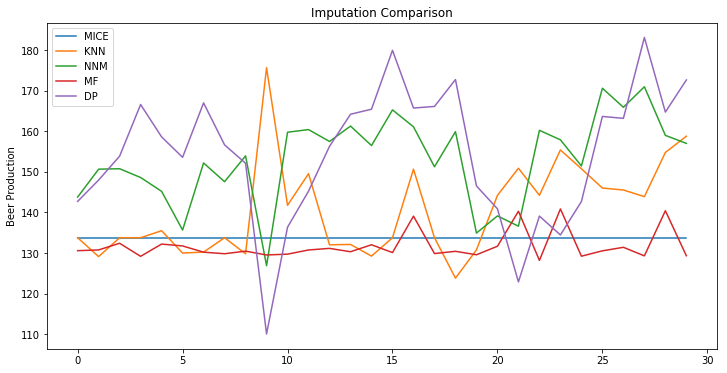

In [159]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(ip_mice[200:230,0],label='MICE')
plt.plot(ip_knn[200:230,0],label='KNN')
plt.plot(ip_nnm[200:230,0],label='NNM')
plt.plot(ip_mf[200:230,0],label='MF')
plt.plot(ip_dp[200:230,0],label='DP')
plt.legend()
plt.title('Imputation Comparison')
plt.ylabel('Beer Production')